#### <h1 align=center><font size = 5>Capstone Project -18 : Crop Recommendation System</font></h1>
<h2 align=center><font size = 5>AIML Certification Programme</font></h2>

## Team <br>
1. Anuj Alex (2024AIML009)​
2. Gurbachan Singh Kalwan (2024AIML004)​
3. Krishna Murthy P (2024AIML078)​
4. Sidharth Gupta (2024AIML017)
5. Sree Rama Kumar Yeddanapudi (2024AILML008)​

Mentor: Prof. Aniruddha Dasgupta

In [1]:
%pip install lightgbm xgboost catboost rapidfuzz imblearn

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------------------------------------ --- 1.3/1.5 MB 8.5 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 7.8 MB/s  0:00:00
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
    --------------------------------------- 1.0/72.0 MB 5.8 MB/s eta 0:00:13
   - -------------------------------------- 2.1/72.0 MB 6.6 MB/s eta 0:00:11
   - -------------------------------------- 2.4/72.0 MB 4.6 MB/s eta 0:00:16
   - -------------------------------------- 2.6/72.0 MB 3.8 MB/s eta 0:00:19
   - -------------------------------------- 3.1/72.0 MB 3.0 MB/s eta 0:00:23
   - -------------------------------------- 3.4/72.0 MB 2.8 MB/s eta 0:00:25
   -- ------------------------------------- 3.7/72.0 MB 2.6 MB/s eta 0:00:26
   -- ------------------------------------- 3.9/72.0 MB 2.5 MB/s eta 0:00:28
   -- ------------------------------------- 4.5/72.0 MB 2.4 MB/s eta 0:00:29
   -- -------------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np # linear algebra
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier # Import DecisionTreeClassifier
import re
from rapidfuzz import process, fuzz
import pickle # Import the pickle library
from sklearn.feature_selection import mutual_info_classif # Import mutual_info_classif

### 1. Loading and Reading Dataset

In [4]:
df = pd.read_csv("../data/AP_data.csv")
df.rename(columns={"Extent\n(AC)":"Farm_Acres","Crop before":"Crop_Sown"},inplace=True)
df['District'] = df['District'].replace({
    "Anantapur": "Ananthapur",
    "S.P.S.Nellore": "Nellore",
    "S.P.S. Nellore": "Nellore",
    "Kadapa YSR": "Kadapa"
})
df.head()

,Sl no,Date,Farmer No,Macro/ Micro nutrient,Farmer Name,District,Mandal,Village,Latitude,Longitude,...,Avail-Mg,Avail-S,Avail-Zn,Avail-B,Avail-Fe,Avail-Cu,Avail-Mn,Time,Season,Recommended Sowing Time
0,1.0,1/1/2015,1910,RK2276,P.Krishna Naik,Ananthapur,Penukonda,Gonipeta,14.08,77.69,...,101.0,5.16,0.30,0.17,8.89,0.51,15.24,1/1/2015,Kharif & Rabi,Kharif: June - July & Rabi: October - November
1,2.0,1/1/2015,1911,RK2277,Kallu Thippe Naik,Ananthapur,Penukonda,Gonipeta,14.09,77.69,...,261.0,9.91,0.36,0.57,3.24,0.44,6.90,1/1/2015,Kharif & Rabi,Kharif: June - July & Rabi: October - November
2,3.0,1/1/2015,1912,RK2278,P.Duble Bai,Ananthapur,Penukonda,Gonipeta,14.09,77.69,...,48.0,3.77,0.37,0.19,5.54,0.42,8.34,1/1/2015,Kharif & Rabi,Kharif: June - July & Rabi: October - November
3,4.0,1/1/2015,1913,RK2279,H.Marekka (Kamma),Ananthapur,Penukonda,Gonipeta,14.10,77.70,...,52.0,4.14,0.23,0.21,1.79,0.67,4.17,1/1/2015,Rabi,September - October
4,5.0,1/1/2015,1914,RK2280,M.Alevelamma,Ananthapur,Penukonda,Gonipeta,14.09,77.69,...,84.0,1.45,0.36,0.22,22.26,0.45,9.20,1/1/2015,Rabi,September - October


In [5]:
dist_master = pd.read_csv("../data/AP_district_level_master.csv")
dist_master.head()

,State,District,Soil_Percent,N_per_Ha,P_per_Ha,K_per_Ha,Kharif_rain,Rabi_rain,Zaid_rain,Area,Rank,Stand_Soil,Stand_Crop
0,Andhra Pradesh,Ananthapur,100.0,27.71,17.96,6.99,272.0,148.0,77.0,594.740,1.0,Sandy,['Groundnut']
1,Andhra Pradesh,Ananthapur,100.0,27.71,17.96,6.99,272.0,148.0,77.0,586.860,2.0,Sandy,['Other']
2,Andhra Pradesh,Ananthapur,100.0,27.71,17.96,6.99,272.0,148.0,77.0,51.825,3.0,Sandy,['Rice']
3,Andhra Pradesh,Ananthapur,100.0,27.71,17.96,6.99,272.0,148.0,77.0,43.055,4.0,Sandy,['Other']
4,Andhra Pradesh,Ananthapur,100.0,27.71,17.96,6.99,272.0,148.0,77.0,24.800,5.0,Sandy,['Pigeonpea']


## 1.1 Merge datasets

The two data sources are merged on the District column to create a unified DataFrame.

In [6]:
# Merge the DataFrames using left_on and right_on
rain_df= dist_master[["District","Kharif_rain", "Rabi_rain",    "Zaid_rain"]].drop_duplicates()
# print(rain_df.head())
merged_df = pd.merge(df,rain_df, left_on='District', right_on='District',how='left')

### 1.2 Remove unnecessary columns

In [7]:
merged_df.drop(columns=["Sl no", "Date", "Farmer No", "Macro/ Micro nutrient", "Farmer Name", "Fathers Name", "Time"
                        , "Recommended Sowing Time", "Season", "Farm_Acres", "Survey No.","Latitude","Longitude"], inplace=True)

In [8]:
orig_df = df
df = merged_df

### 1.3 Check basic data statistics (shape, info, describe)

In [9]:
df.shape

(4816, 21)

In [10]:
df.describe()

,pH,EC,Avail-P,Exch-K,Avail-Ca,Avail-Mg,Avail-Zn,Avail-Fe,Avail-Cu,Avail-Mn,Kharif_rain,Rabi_rain,Zaid_rain
count,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000
mean,7.477844,0.489531,16.704285,159.676012,2416.086604,522.878920,1.111973,28.349657,2.533325,18.805155,503.790447,311.759917,74.812461
std,1.052134,1.045581,18.810818,135.616280,2155.234533,473.764527,1.396243,38.578050,3.061383,18.965475,169.263499,151.074131,19.353745
min,4.150000,0.010000,0.450000,12.000000,20.000000,2.000000,0.030000,0.040000,0.030000,0.010000,272.000000,125.000000,49.000000
25%,6.740000,0.110000,5.160000,82.000000,839.000000,184.000000,0.410000,5.780000,0.930000,8.100000,404.000000,235.000000,55.000000
50%,7.810000,0.220000,10.930000,129.000000,1652.000000,374.000000,0.700000,12.210000,1.460000,12.960000,455.000000,270.000000,70.000000
75%,8.270000,0.510000,21.410000,196.000000,3150.500000,715.500000,1.250000,33.980000,2.600000,22.125000,699.000000,375.000000,94.000000
max,9.890000,27.500000,361.940000,2409.000000,13304.000000,5363.000000,23.920000,354.700000,20.180000,256.880000,806.000000,710.000000,109.000000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4816 entries, 0 to 4815
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   District     4815 non-null   object 
 1   Mandal       4815 non-null   object 
 2   Village      4815 non-null   object 
 3   Soil type    4749 non-null   object 
 4   Crop_Sown    4595 non-null   object 
 5   pH           4815 non-null   float64
 6   EC           4815 non-null   float64
 7   OC           4815 non-null   object 
 8   Avail-P      4815 non-null   float64
 9   Exch-K       4815 non-null   float64
 10  Avail-Ca     4815 non-null   float64
 11  Avail-Mg     4815 non-null   float64
 12  Avail-S      4815 non-null   object 
 13  Avail-Zn     4815 non-null   float64
 14  Avail-B      4815 non-null   object 
 15  Avail-Fe     4815 non-null   float64
 16  Avail-Cu     4815 non-null   float64
 17  Avail-Mn     4815 non-null   float64
 18  Kharif_rain  4815 non-null   float64
 19  Rabi_r

### 1.4 Display unique and sample values for columns

In [12]:
for col in df.columns:
    print(col, df[col].nunique(),df[col].unique()[0:20],'\n')

District 13 ['Ananthapur' 'Chittoor' 'East Godavari' 'Guntur' 'Kadapa' 'Krishna'
 'Kurnool' 'Nellore' 'Prakasam' 'Srikakulam' 'Visakhapatnam'
 'Vizianagaram' 'West Godavari' nan] 

Mandal 31 ['Penukonda' 'Raptadu' 'Santipuram' 'V.Kota' 'Gangavaram' 'Kollur'
 'Sattenapalli' 'B Mattam' 'Porumamilla' 'Sambepalli' 'Veeraballi'
 'G Konduru' 'Ghantasala' 'Banaganpalli' 'Devanakonda' 'Indukurpeta'
 'Podalakuru' 'T.P.Gudur' 'Kanigiri' 'Konakana Mitta'] 

Village 251 ['Gonipeta' 'Kondampalli' 'Settipalli' 'G.Koythapally' 'Gandlaparthi'
 'Gollapalli' 'Palbhavi' 'Pesarakunta' 'Pullalarevu' 'Raminepally'
 '121.Pedduru' '30.Sonneganipalle' 'Bellakogilla' 'Bendamakuppam'
 'Chinnaridoddi' 'Dandikuppam' 'Kadapalle' 'Kenumakulapalle'
 'Konerukuppam' 'Settiballa'] 

Soil type 99 ['Mixed soil' 'Redsoil' 'Sandi soil' 'Red soil' 'Black Soil' 'Sandy soil'
 'RED' 'BLACK' nan 'SAND' 'Red' 'Black' 'red' 'Rock soil' '-' 'Sandy Red'
 'Red Sandy' 'Sandy' 'Black Sandy' 'Claim'] 

Crop_Sown 129 ['Ground Nut' 'Horse

### 2. Data Preprocessing

### 2.1 Check for Data Quality Issues

* duplicate data
* missing data
* data inconsistencies

In [13]:
# duplicate data
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 1


In [14]:
# missing data
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]
print(missing_data.sort_values(ascending = False))

Crop_Sown      221
Soil type       67
District         1
Village          1
Mandal           1
pH               1
EC               1
OC               1
Avail-P          1
Exch-K           1
Avail-Ca         1
Avail-Mg         1
Avail-S          1
Avail-Zn         1
Avail-B          1
Avail-Fe         1
Avail-Cu         1
Avail-Mn         1
Kharif_rain      1
Rabi_rain        1
Zaid_rain        1
dtype: int64


### 2.2 Handle missing values for numerical attributes

In [15]:
numerical_cols = df.select_dtypes(include=['float64','int64']).columns

In [16]:
numerical_cols

Index(['pH', 'EC', 'Avail-P', 'Exch-K', 'Avail-Ca', 'Avail-Mg', 'Avail-Zn',
       'Avail-Fe', 'Avail-Cu', 'Avail-Mn', 'Kharif_rain', 'Rabi_rain',
       'Zaid_rain'],
      dtype='object')

In [17]:
for col in numerical_cols:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)

In [18]:
# missing data
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]
print(missing_data.sort_values(ascending = False))

Crop_Sown    221
Soil type     67
Mandal         1
District       1
Village        1
OC             1
Avail-S        1
Avail-B        1
dtype: int64


### 2.3 Handle missing values for Soil

In [19]:
# --- Master Soil categories ---
master_categories = [
    "Black", "Red", "Sandy", "Loam", "Clay",
    "Brown", "Yellow", "White", "Laterite",
    "Saline", "Alkaline", "Alluvial",
    "Gravel/Stony", "Mixed", "Other"
]

# --- Known corrections / synonyms ---
direct_map = {
    # Misspellings
    "RED": "Red",
    "red": "Red",
    "Red soil": "Red",
    "res": "Red",
    "redsoil": "Red",
    "redsoils": "Red",
    "red sandy loam": "Red",
    "red sandy": "Red",
    "red sandy\\": "Red",
    "redsandy": "Red",
    "redsandylo": "Red",
    "redsand": "Red",
    "redloam": "Red",
    "redbrown": "Red",
    "red grey": "Red",
    "red masari": "Red",

    "black soil": "Black",
    "Black Soil": "Black",
    "BLACK": "Black",
    "black clay": "Black",
    "black sandy": "Black",
    "black sandy loam": "Black",
    "black loam": "Black",
    "deepblack": "Black",
    "deep black": "Black",
    "normal bla": "Black",
    "black mix": "Black",
    "black mara": "Black",


    "sandi": "Sandy",
    "sanday": "Sandy",
    "sanday+bla": "Sandy",
    "sanday mix": "Sandy",
    "sand mixed": "Sandy",
    "sand mix": "Sandy",
    "sandy loam": "Sandy",
    "sandy mixe": "Sandy",
    "sandy with": "Sandy",
    "sandy brow": "Sandy",
    "sandy whit": "Sandy",


    "clayey loam": "Clay",
    "clay soil": "Clay",
    "caly soil": "Clay",
    "clay-sandy": "Clay",
    "silty clay": "Clay",

    "broan clay": "Brown",
    "brown light": "Brown",
    "brown dark": "Brown",
    "light brow": "Brown",
    "dark brown": "Brown",

    "alkhaline": "Alkaline",
    "alkline": "Alkaline",
    "alkline +": "Alkaline",
    "black alka": "Alkaline",

    "saline soi": "Saline",
    "salain": "Saline",
    "salty": "Saline",
    "salain mix": "Saline",
    "saline mix": "Saline",

    "laterite s": "Laterite",
    "laterite l": "Laterite",
    "laterite m": "Laterite",
    "laterite u": "Laterite",
    "latritate": "Laterite",
    "red lateri": "Laterite",

    "loamy soil": "Loam",
    "loomy": "Loam",
    "loami": "Loam",
    "laomy": "Loam",
    "soil loamy": "Loam",
    "loamy brow": "Loam",
    "ORTHIDS": "Loam",

    "white gara": "White",
    "white mixe": "White",
    "white soil": "White",
    "whitebrown": "White",
    "white sand": "White",
    "white red": "White",
    "white yell": "White",
    "brown whit": "White",

    "yellowblac": "Yellow",
    "yellowbrow": "Yellow",
    "yellow red": "Yellow",
    "white yello": "Yellow",

    # Loam/Alluvial
    "alluvial s": "Alluvial",
}
direct_map.update({
    # Sandy soils
    "SANDY ALFISOL": "Sandy",
    "SANDY ALFISOLS": "Sandy",
    "PSSAMENTS": "Sandy",
    "PSSAMNETS": "Sandy",
    "INNCEPTISOLS": "Sandy",
    "INSEPTISOLS": "Sandy",

    # Loam soils / Alfisols / Inceptisols variants
    "ORTHIDS": "Loam",
    "LOAMY ALFISOLS": "Loam",
    "LOAMY ALFISOL": "Loam",
    "USTALF/USTOLLS": "Loam",
    "UDUPTS/UDALFS": "Loam",
    "UDOLLS/UDALFS": "Loam",
    "INCEPTISOLS": "Loam",

    # Black soils / Vertisols variants
    "VERTISOLS": "Black",
    "VERTIC SOILS": "Black",
    "VERTIC SOLS": "Black",
    "VERTI SOLS": "Black",
    "VRTIC SOILS": "Black",
    "VERRTISOLS": "Black",
    "VERTIC OSILS": "Black",
})
# --- Local overrides (dialect → base class) ---
overrides = {
    "chowdu": "Red",
    "nalla regadi": "Red",
    "regadi": "Red",
    "sowdu": "Red",
    "sudda": "Red",
    "thella kattu": "Red",
    "sudda neela": "Red",
    "tella masaka": "Red",
    "erra maska": "Red",
    "savudu": "Red",
    "garuku": "Other",
    "garasu": "Red",
    "garasu mix": "Red",
    "garsu mix": "Red",
    "mosari": "Red",
    "masari": "Red",
    "masali": "Red",
    "masale": "Red",
    "masori": "Red",
    "madikattu": "Red",
    "maradi": "Red",
    "marad": "Red",
    "mardi": "Red",
    "marali": "Red",
    "moram": "Red",
    "maralugodu": "Red",

    "murrum": "Black",
    "murum soil": "Black",
    "medium bla": "Black",
    "m black": "Black",
    "black muri": "Black",
    "humpli bla": "Black",

    "kari": "Black",
    "kapu": "Black",
    "kappu": "Black",

    "kemp": "Red",
    "kempu": "Red",
    "k-r": "Red",
    "r-k": "Red",
    "r-m": "Red",
    "m-r": "Red",
}

In [20]:
print(master_categories)

['Black', 'Red', 'Sandy', 'Loam', 'Clay', 'Brown', 'Yellow', 'White', 'Laterite', 'Saline', 'Alkaline', 'Alluvial', 'Gravel/Stony', 'Mixed', 'Other']


In [21]:
print(direct_map)

{'RED': 'Red', 'red': 'Red', 'Red soil': 'Red', 'res': 'Red', 'redsoil': 'Red', 'redsoils': 'Red', 'red sandy loam': 'Red', 'red sandy': 'Red', 'red sandy\\': 'Red', 'redsandy': 'Red', 'redsandylo': 'Red', 'redsand': 'Red', 'redloam': 'Red', 'redbrown': 'Red', 'red grey': 'Red', 'red masari': 'Red', 'black soil': 'Black', 'Black Soil': 'Black', 'BLACK': 'Black', 'black clay': 'Black', 'black sandy': 'Black', 'black sandy loam': 'Black', 'black loam': 'Black', 'deepblack': 'Black', 'deep black': 'Black', 'normal bla': 'Black', 'black mix': 'Black', 'black mara': 'Black', 'sandi': 'Sandy', 'sanday': 'Sandy', 'sanday+bla': 'Sandy', 'sanday mix': 'Sandy', 'sand mixed': 'Sandy', 'sand mix': 'Sandy', 'sandy loam': 'Sandy', 'sandy mixe': 'Sandy', 'sandy with': 'Sandy', 'sandy brow': 'Sandy', 'sandy whit': 'Sandy', 'clayey loam': 'Clay', 'clay soil': 'Clay', 'caly soil': 'Clay', 'clay-sandy': 'Clay', 'silty clay': 'Clay', 'broan clay': 'Brown', 'brown light': 'Brown', 'brown dark': 'Brown', 'l

In [22]:
def clean_text(txt: str) -> str:
    txt = str(txt).lower().strip()
    txt = re.sub(r"soil", "", txt)
    txt = re.sub(r"[^a-z\s\+\-]", "", txt)
    return txt.strip()

In [23]:
def standardize_soil(raw: str) -> str:
    if not raw or not isinstance(raw, str) or raw.strip() == "":
        return "Other"

    text = clean_text(raw)
    for key, val in overrides.items():
        if key in text:
            return val
    if text in direct_map:
        return direct_map[text]

    match, score, _ = process.extractOne(text, master_categories, scorer=fuzz.WRatio)
    if score >= 80:
        return match
    return "Other"

In [24]:
# def standardize_soil(raw: str) -> str:
#     if not raw or not isinstance(raw, str) or raw.strip() == "":
#         return "Other"

#     text = clean_text(raw)
#     for key, val in overrides.items():
#         if key in text:
#             return val
#     if text in direct_map:
#         return direct_map[text]

#     match, score, _ = process.extractOne(text, master_categories, scorer=fuzz.WRatio)
#     if score >= 80:
#         return match
#     return "Other"

In [25]:
# # Test Soil Function works for samples
samples = [
"Black Soil", "redsoil", "Chowdu", "Alkline +",
"Saline Soi", "Laterite m", "Broan Clay",
"Sanday+bla", "White gara", "Masari", "Murum Soil",
"nalla regadi", "redsandylo", "Random Gibberish", "", None
 ]

print("--- Soil Type Standardization Examples ---")
for s in samples:
    # For each sample, print the original string and its standardized version
    standardized_value = standardize_soil(s)
    print(f"'{s}' → '{standardized_value}'")

--- Soil Type Standardization Examples ---
'Black Soil' → 'Black'
'redsoil' → 'Red'
'Chowdu' → 'Red'
'Alkline +' → 'Alkaline'
'Saline Soi' → 'Saline'
'Laterite m' → 'Laterite'
'Broan Clay' → 'Brown'
'Sanday+bla' → 'Sandy'
'White gara' → 'White'
'Masari' → 'Red'
'Murum Soil' → 'Other'
'nalla regadi' → 'Red'
'redsandylo' → 'Red'
'Random Gibberish' → 'Other'
'' → 'Other'
'None' → 'Other'


### 2.4 Handle missing values for Crop

In [26]:
crop_map = {
    # Cereals (Grains & Millets)
    "maize": "Maize", "mazi": "Maize", "sweetcorn": "Maize",
    "jowar": "Sorghum", "jonna": "Sorghum", "mahendra jonna": "Sorghum",
    "pacha jonna": "Sorghum", "erra jonna": "Sorghum",
    "bajra": "Pearl Millet",
    "korra": "Foxtail Millet",
    "dhanyalu": "Other Millet",
    "ragi": "Ragi",
    "vari": "Rice", "paddy": "Rice", "paady": "Rice",
    "rice": "Rice",
    "millet": "Other Millet",
    "finger millet": "Ragi",
    "pearl millet": "Pearl Millet",
    "wheat": "Wheat",
    "barley": "Barley",

    # Pulses
    "bengalgram": "Chickpea", "senaga": "Chickpea", "erra senaga": "Chickpea",
    "chickpea": "Chickpea",
    "red gram": "Pigeonpea", "redgram": "Pigeonpea",
    "pigeonpea": "Pigeonpea",
    "green gram": "Green Gram", "mung": "Green Gram",
    "black gram": "Black Gram", "blackgram": "Black Gram",
    "horse gram": "Horse Gram", "horsegram": "Horse Gram",
    "cowpea": "Cowpea", "cow pea": "Cowpea",
    "rajma": "Rajma", "peasara": "Other Pulse", "pulse": "Other Pulse",
    "minor pulses": "Other Pulse",

    # Oilseeds
    "ground nut": "Groundnut", "groundnut": "Groundnut", "g.nut": "Groundnut",
    "grounat": "Groundnut", "ground nat": "Groundnut",
    "veru senaga": "Groundnut",
    "castor": "Castor", "clastor": "Castor",
    "sesamum": "Sesame", "sesumum": "Sesame",
    "sunflower": "Sunflower",
    "linseed": "Linseed",
    "rapeseed": "Rapeseed and Mustard", "mustard": "Rapeseed and Mustard",
    "soyabean": "Soyabean", "soybean": "Soyabean",
    "safflower": "Safflower",

    # Cash crops
    "cotton": "Cotton", "cottan": "Cotton",
    "sugarcane": "Sugarcane", "suger cane": "Sugarcane",
    "sugar cane": "Sugarcane",
    "tobacco": "Tobacco", "pogaku": "Tobacco",
    "oil palm": "Oil Palm",
    "eucalyptus": "Eucalyptus", "eucaliptus": "Eucalyptus",

    # Fruits
    "banana": "Banana", "cocnut": "Coconut", "coconut": "Coconut",
    "papaya": "Papaya", "anaar": "Pomegranate",
    "mango": "Mango",
    "citrus": "Citrus",
    "lime": "Lime", "lemon": "Lime",
    "cashew": "Cashew", "cashewnut": "Cashew", "cashew nut": "Cashew",
    "cashew raina": "Cashew",
    "cocoa": "Cocoa", "cocoa+ coconut": "Cocoa",
    "fruits": "Fruits",

    # Vegetables
    "brinjal": "Brinjal",
    "tomato": "Tomato", "tamato": "Tomato",
    "benda": "Okra", "okra": "Okra",
    "cabbage": "Cabbage", "cabage": "Cabbage",
    "cucumber": "Cucumber",
    "potato": "Potato", "potatao": "Potato", "potatoes": "Potato",
    "onion": "Onion", "onian": "Onion", "oniyan": "Onion",
    "ridge guard": "Ridge Gourd", "donda": "Ridge Gourd",
    "yam": "Yam",
    "vegetable": "Vegetables", "vegetables": "Vegetables",

    # Spices & condiments
    "chilli": "Chilli", "chill": "Chilli", "chillies": "Chilli",
    "chilly": "Chilli", "mirchi": "Chilli",
    "turmeric": "Turmeric", "turmaric": "Turmeric",
    "coriandam": "Coriander",

    # Plantation crops
    "mulberry": "Mulberry", "mulbarry": "Mulberry", "mulberrry": "Mulberry",
    "coffee": "Coffee",
    "red sandal": "Sandalwood", "sandal": "Sandalwood",

    # Others
    "fodder crops": "Fodder", "fodder": "Fodder",
    "flowers": "Flowers",
    "prawns": "Aquaculture",
}

In [27]:
def standardize_crop(raw: str) -> list[str]:
    if not isinstance(raw, str) or not raw.strip(): return ["Other"]
    text = raw.lower()
    text = re.sub(r'[/;()$$$$+]', ',', text)
    text = re.sub(r'\b(intercrop|and|crops?)\b', ',', text, flags=re.IGNORECASE)
    potential_crops = [c.strip() for c in text.split(',') if c.strip()]
    standardized_crops = set()
    for crop_text in potential_crops:
        if crop_text in crop_map:
            standardized_crops.add(crop_map[crop_text])
            continue
        match, score, _ = process.extractOne(crop_text, crop_map.keys(), scorer=fuzz.WRatio)
        if score >= 85:
            standardized_crops.add(crop_map[match])
    if not standardized_crops: return ["Other"]
    return sorted(list(standardized_crops))

In [28]:
# # Test Crop Function works for samples
tests = [
"Cashewnut, Mango (Intercrop Maize And Seasamum)",
"Topioca, Cashew",
"Paddy/Maize/G.Nut",
"Cotton;Red Gram",
"Oil Palm+Coconut",
"Paddy/ Sugarcane",
"Mirchi",
"Erra Senaga"
]

for t in tests:
    print(t, "→", standardize_crop(t))

Cashewnut, Mango (Intercrop Maize And Seasamum) → ['Cashew', 'Maize', 'Mango', 'Sesame']
Topioca, Cashew → ['Cashew']
Paddy/Maize/G.Nut → ['Groundnut', 'Maize', 'Rice']
Cotton;Red Gram → ['Cotton', 'Pigeonpea']
Oil Palm+Coconut → ['Coconut', 'Oil Palm']
Paddy/ Sugarcane → ['Rice', 'Sugarcane']
Mirchi → ['Chilli']
Erra Senaga → ['Chickpea']


In [29]:
ranked_soil_crop_map = {
    "Black": {1: ["Cotton", "Sorghum", "Pigeonpea"], 2: ["Sunflower", "Chilli", "Soybean", "Pomegranate"], 3: ["Groundnut", "Sugarcane"]},
    "Red": {1: ["Groundnut", "Castor", "Horse Gram", "Pigeonpea"], 2: ["Sorghum", "Foxtail Millet", "Pearl Millet", "Tomato", "Chilli"], 3: ["Mango", "Cashew", "Mulberry"]},
    "Loam": {1: ["Paddy", "Maize", "Groundnut", "Sunflower"], 2: ["Banana", "Tomato", "Brinjal", "Onion", "Potato"], 3: ["Sugarcane", "Turmeric", "Coriander"]},
    "Alluvial": {1: ["Paddy", "Sugarcane", "Maize"], 2: ["Banana", "Potato", "Onion", "Brinjal"], 3: ["Groundnut", "Pulses", "Papaya"]},
    "Laterite": {1: ["Coconut", "Cashew", "Coffee"], 2: ["Mango", "Oil Palm", "Eucalyptus"], 3: ["Sandalwood"]},
    "Sandy": {1: ["Groundnut", "Cowpea", "Castor"], 2: ["Watermelon", "Cucumber", "Vegetables"], 3: ["Sunflower", "Sesamum"]},
    "Clay": {1: ["Paddy"], 2: ["Sugarcane"], 3: ["Banana"]},
    "Saline": {1: ["Cotton"], 2: ["Paddy"], 3: ["Eucalyptus"]},
    "Alkaline": {1: ["Cotton"], 2: ["Paddy"], 3: ["Eucalyptus"]},
}

In [30]:
def get_ranked_crops(soil):
    return ranked_soil_crop_map.get(soil, {})

In [31]:
# def get_crop_recommendations(soil_type_raw: str):
#     """
#     Standardizes a raw soil type and provides ranked crop recommendations.
#     """
#     # 1. Standardize the input soil type
#     standardized_soil = standardize_soil(soil_type_raw)
#     print(f"Input Soil: '{soil_type_raw}' → Standardized as: '{standardized_soil}'")

#     # 2. Retrieve the ranked list of crops
#     recommendations = get_ranked_crops(standardized_soil)

#     # 3. Display the results
#     if not recommendations:
#         print(f"-> No specific crop recommendations found for '{standardized_soil}' soil.")
#     else:
#         print("-> Crop Recommendations:")
#         for rank, crops in sorted(recommendations.items()):
#             rank_desc = {1: "Most Suitable", 2: "Moderately Suitable", 3: "Less Suitable"}
#             print(f"  - Rank {rank} ({rank_desc.get(rank, '')}): {', '.join(crops)}")

# # --- Example Usage ---
# print("\n--- Crop Recommendation Example ---")
# get_crop_recommendations("Nalla Regadi")

In [32]:
# 2. Standardize Soil Type
df['Soil_Type_Standard'] = df['Soil type'].apply(standardize_soil) # Moved to cell ac2f1768-2649-4692-9e23-7e25bcf9e5cc
df['Crop_Sown_Standard'] = df['Crop_Sown'].apply(standardize_crop) # This line was moved from cell 3rAJZFSHkNEY

In [33]:
df.drop(columns=["Soil type", "Crop_Sown"], inplace=True)

In [34]:
# missing data
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]
print(missing_data.sort_values(ascending = False))

District    1
Mandal      1
Village     1
OC          1
Avail-S     1
Avail-B     1
dtype: int64


### 3. Exploratory Data Analysis

### 3.1 EDA - Soil Distribution

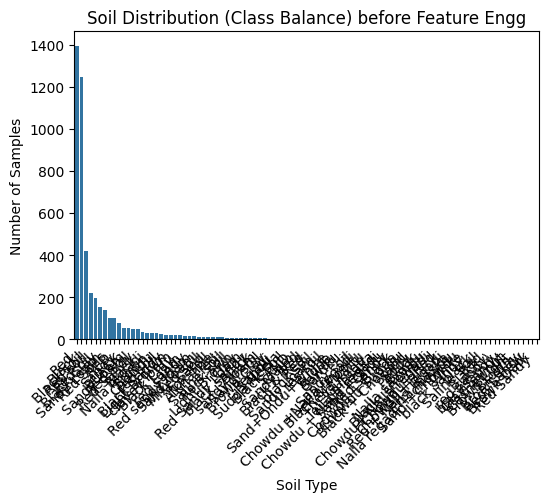

In [35]:
plt.figure(figsize=(6, 4))
soil_counts_orig = orig_df['Soil type'].value_counts()
sns.barplot(x=soil_counts_orig.index, y=soil_counts_orig.values)
plt.title('Soil Distribution (Class Balance) before Feature Engg')
plt.xlabel('Soil Type')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.show()

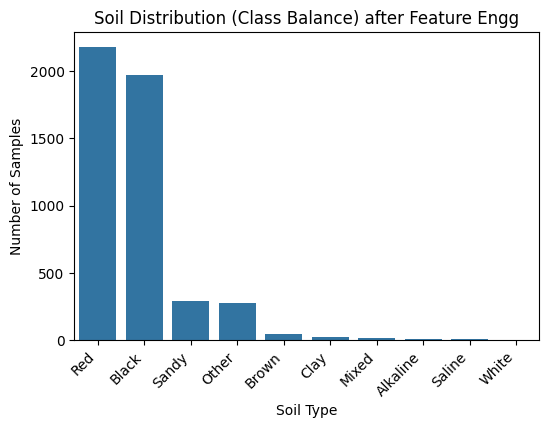

In [36]:
plt.figure(figsize=(6, 4))
soil_counts = df['Soil_Type_Standard'].value_counts()
sns.barplot(x=soil_counts.index, y=soil_counts.values)
plt.title('Soil Distribution (Class Balance) after Feature Engg')
plt.xlabel('Soil Type')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.show()

### 3.2 EDA - Crop Distribution

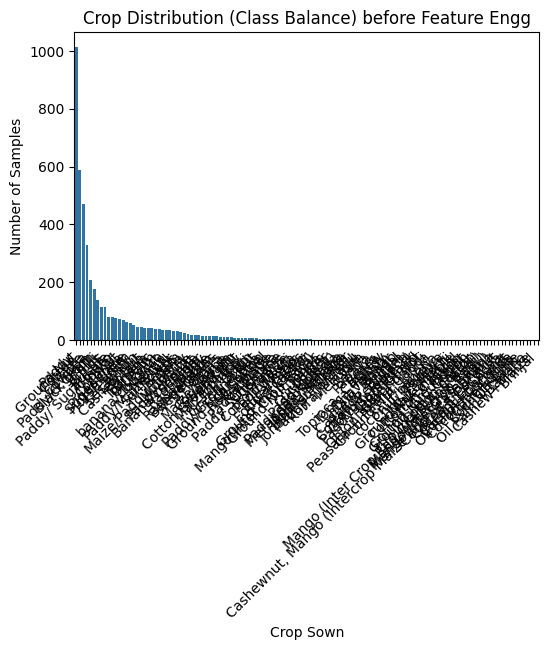

In [37]:
plt.figure(figsize=(6, 4))
soil_counts_orig = orig_df['Crop_Sown'].value_counts()
sns.barplot(x=soil_counts_orig.index, y=soil_counts_orig.values)
plt.title('Crop Distribution (Class Balance) before Feature Engg')
plt.xlabel('Crop Sown')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.show()

In [38]:
# Extract first element from each list
df['First_Crop'] = df['Crop_Sown_Standard'].apply(lambda x: x[0] if isinstance(x, list) and x else None)
df_EDA = df
df.drop(columns=["Crop_Sown_Standard"], inplace=True)

In [39]:
top_25_crops = df['First_Crop'].value_counts().head(25).index.tolist()

# Replace crops not in top 5 with 'others'
df['First_Crop'] = df['First_Crop'].apply(lambda x: x if x in top_25_crops else 'Other')

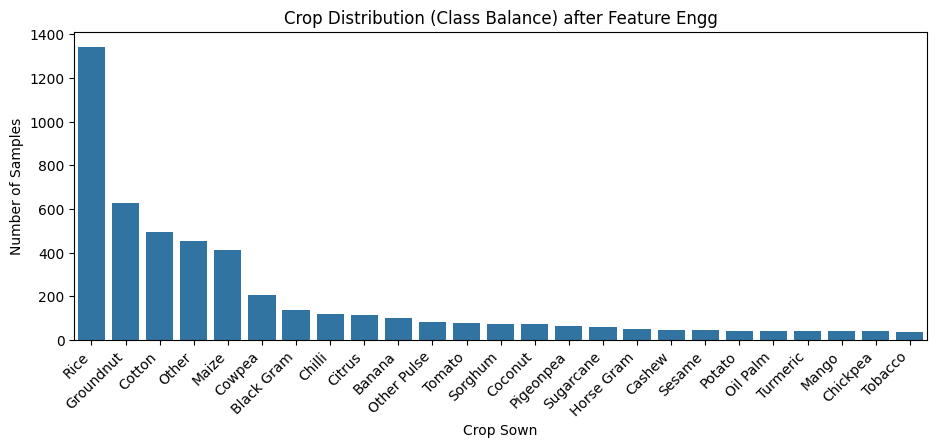

In [40]:
plt.figure(figsize=(11, 4))
crop_counts = df['First_Crop'].value_counts()
sns.barplot(x=crop_counts.index, y=crop_counts.values)
plt.title('Crop Distribution (Class Balance) after Feature Engg')
plt.xlabel('Crop Sown')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.show()

In [41]:
# # Set plotting style
# sns.set(style="whitegrid")

# # ✔ Distribution of Nutrients
# print("\n--- EDA: Distribution of Nutrients ---")
# # Update nutrient_cols to match the columns in df_processed (using hyphens)
# nutrient_cols = ['pH', 'EC', 'OC', 'Avail-P', 'Exch-K', 'Avail-S', 'Avail-Zn', 'Avail-B', 'Avail-Fe', 'Avail-Cu', 'Avail-Mn']

# plt.figure(figsize=(15, 12))
# for i, col in enumerate(nutrient_cols):
#     plt.subplot(4, 3, i + 1) # Adjust subplot layout
#     sns.histplot(df[col], kde=True, bins=20) # Use df_processed instead of data
#     plt.title(f'Distribution of {col}')
# plt.tight_layout()
# plt.show()

In [42]:
# Select only the numerical features for plotting
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
# Remove non-sensical or ID-like columns from plotting
cols_to_exclude = [col for col in ['Sl no', 'Farmer No', 'Survey No.', 'Latitude', 'Longitude', 'Extent\n(AC)'] if col in numerical_features]
numerical_features = [col for col in numerical_features if col not in cols_to_exclude]

# Apply log transformation (using log1p to handle zero values gracefully)
df_log_transformed = df[numerical_features].apply(np.log1p)

PLOTTING: DISTRIBUTION OF LOG-TRANSFORMED VARIABLES

--- Generating Histograms for Log-Transformed Numerical Features ---


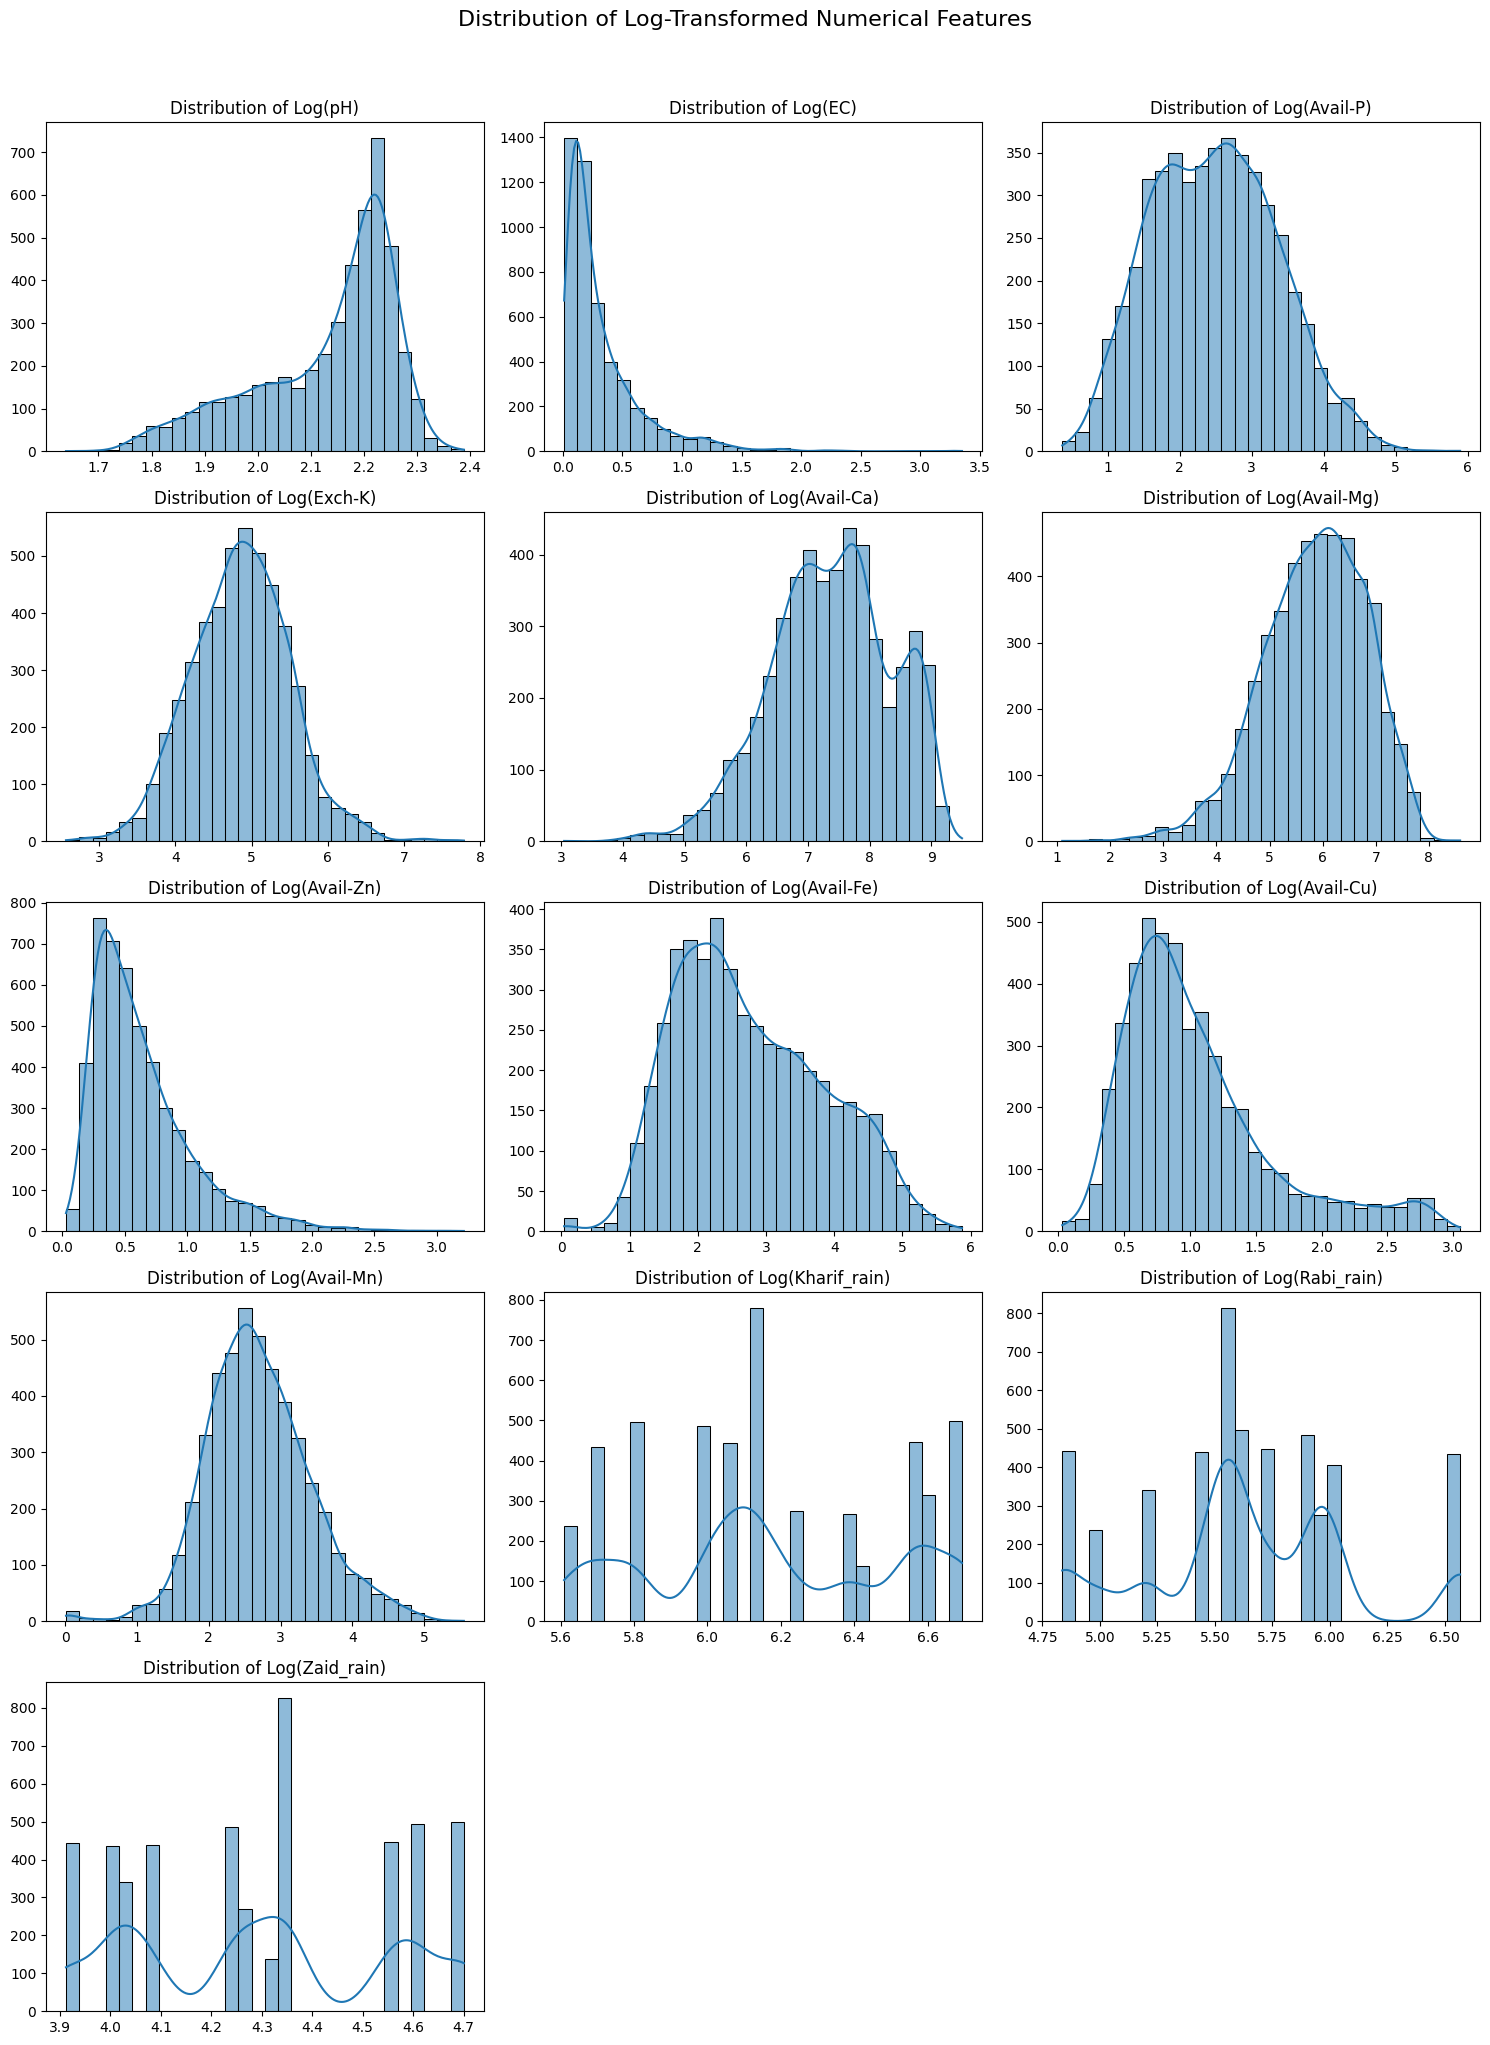

In [43]:
print("--- Generating Histograms for Log-Transformed Numerical Features ---")

# Determine grid size for subplots
n_features = len(numerical_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

# Create the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(df_log_transformed.columns):
    sns.histplot(df_log_transformed[col], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f'Distribution of Log({col})', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle('Distribution of Log-Transformed Numerical Features', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [46]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [47]:
try:
    df_main = pd.read_csv("../data/AP_data.csv")
    df_master = pd.read_csv("../data/AP_district_level_master.csv")
except FileNotFoundError:
    print("ERROR: Make sure 'AP_data.csv' and 'AP_district_level_master.csv' are uploaded.")
    raise

In [48]:
df_main.rename(columns={"Extent\n(AC)": "Farm_Acres", "Crop before": "Crop_Sown"}, inplace=True)
df_main['District'] = df_main['District'].replace({"Anantapur": "Ananthapur", "S.P.S.Nellore": "Nellore", "S.P.S. Nellore": "Nellore", "Kadapa YSR": "Kadapa"})
rain_df = df_master[["District", "Kharif_rain", "Rabi_rain", "Zaid_rain"]].drop_duplicates().dropna()
df = pd.merge(df_main, rain_df, on='District', how='left')
cols_to_drop = ["Sl no", "Date", "Farmer No", "Macro/ Micro nutrient", "Farmer Name", "Fathers Name", "Time", "Recommended Sowing Time", "Season", "Farm_Acres", "Survey No.", "Latitude", "Longitude"]
df.drop(columns=[c for c in cols_to_drop if c in df.columns], inplace=True)
for col in ['OC', 'Avail-S', 'Avail-B']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
df.drop_duplicates(inplace=True)
numerical_cols = df.select_dtypes(include=np.number).columns
for col in numerical_cols:
    df[col].fillna(df[col].median(), inplace=True)
df.dropna(subset=['District', 'Mandal', 'Village', 'Soil type', 'Crop_Sown'], inplace=True)
print("Initial cleaning complete.")

# Feature Engineering & EDA
def standardize_soil(raw: str) -> str:
    master_categories = ["Black", "Red", "Sandy", "Loam", "Clay", "Laterite", "Saline", "Alkaline"]
    text = str(raw).lower().strip()
    if 'red' in text: return 'Red'
    if 'black' in text: return 'Black'
    match, score, _ = process.extractOne(text, master_categories, scorer=fuzz.WRatio)
    return match if score >= 75 else "Other"

def standardize_crop(raw: str) -> str:
    crop_map = {'ground nut': 'Groundnut', 'paddy': 'Rice', 'maize': 'Maize', 'cotton': 'Cotton', 'chilli': 'Chilli', 'sunflower': 'Sunflower', 'horse gram': 'Horse Gram', 'jowar': 'Sorghum', 'bengalgram': 'Chickpea', 'black gram': 'Black Gram', 'green gram': 'Green Gram', 'red gram': 'Pigeonpea', 'sugarcane': 'Sugarcane', 'tomato': 'Tomato', 'turmeric': 'Turmeric', 'banana': 'Banana', 'onion': 'Onion', 'ragi': 'Ragi', 'castor': 'Castor', 'mango': 'Mango', 'cowpea': 'Cowpea', 'sesamum': 'Sesame'}
    if not isinstance(raw, str) or not raw.strip(): return "Other"
    text = raw.lower().strip().split(',')[0].split('/')[0].split('(')[0].strip()
    if text in crop_map: return crop_map[text]
    match, score, _ = process.extractOne(text, crop_map.keys(), scorer=fuzz.WRatio)
    return crop_map[match] if score >= 85 else text.capitalize()

# Apply standardization
df['Soil_Type_Standard'] = df['Soil type'].apply(standardize_soil)
df['First_Crop'] = df['Crop_Sown'].apply(standardize_crop)
df.drop(columns=['Soil type', 'Crop_Sown'], inplace=True)
print("Soil and Crop names standardized.")

# Filter for Top 15 Crops
crop_counts = df['First_Crop'].value_counts()
top_15_crops = crop_counts.head(15).index.tolist()
df_final = df[df['First_Crop'].isin(top_15_crops)].copy()
print(f"Dataset filtered for Top 15 crops. Final rows: {len(df_final)}")

Initial cleaning complete.
Soil and Crop names standardized.
Dataset filtered for Top 15 crops. Final rows: 3951


Correlation Analysis and Feature Selection

To build a more stable and interpretable model, we first analyze the correlation between our numerical features. A heatmap is generated to visualize these relationships. Features with a very high correlation (multicollinearity) add redundant information and can be removed. Based on our analysis, we will programmatically identify and drop any features with a correlation coefficient greater than 0.80.

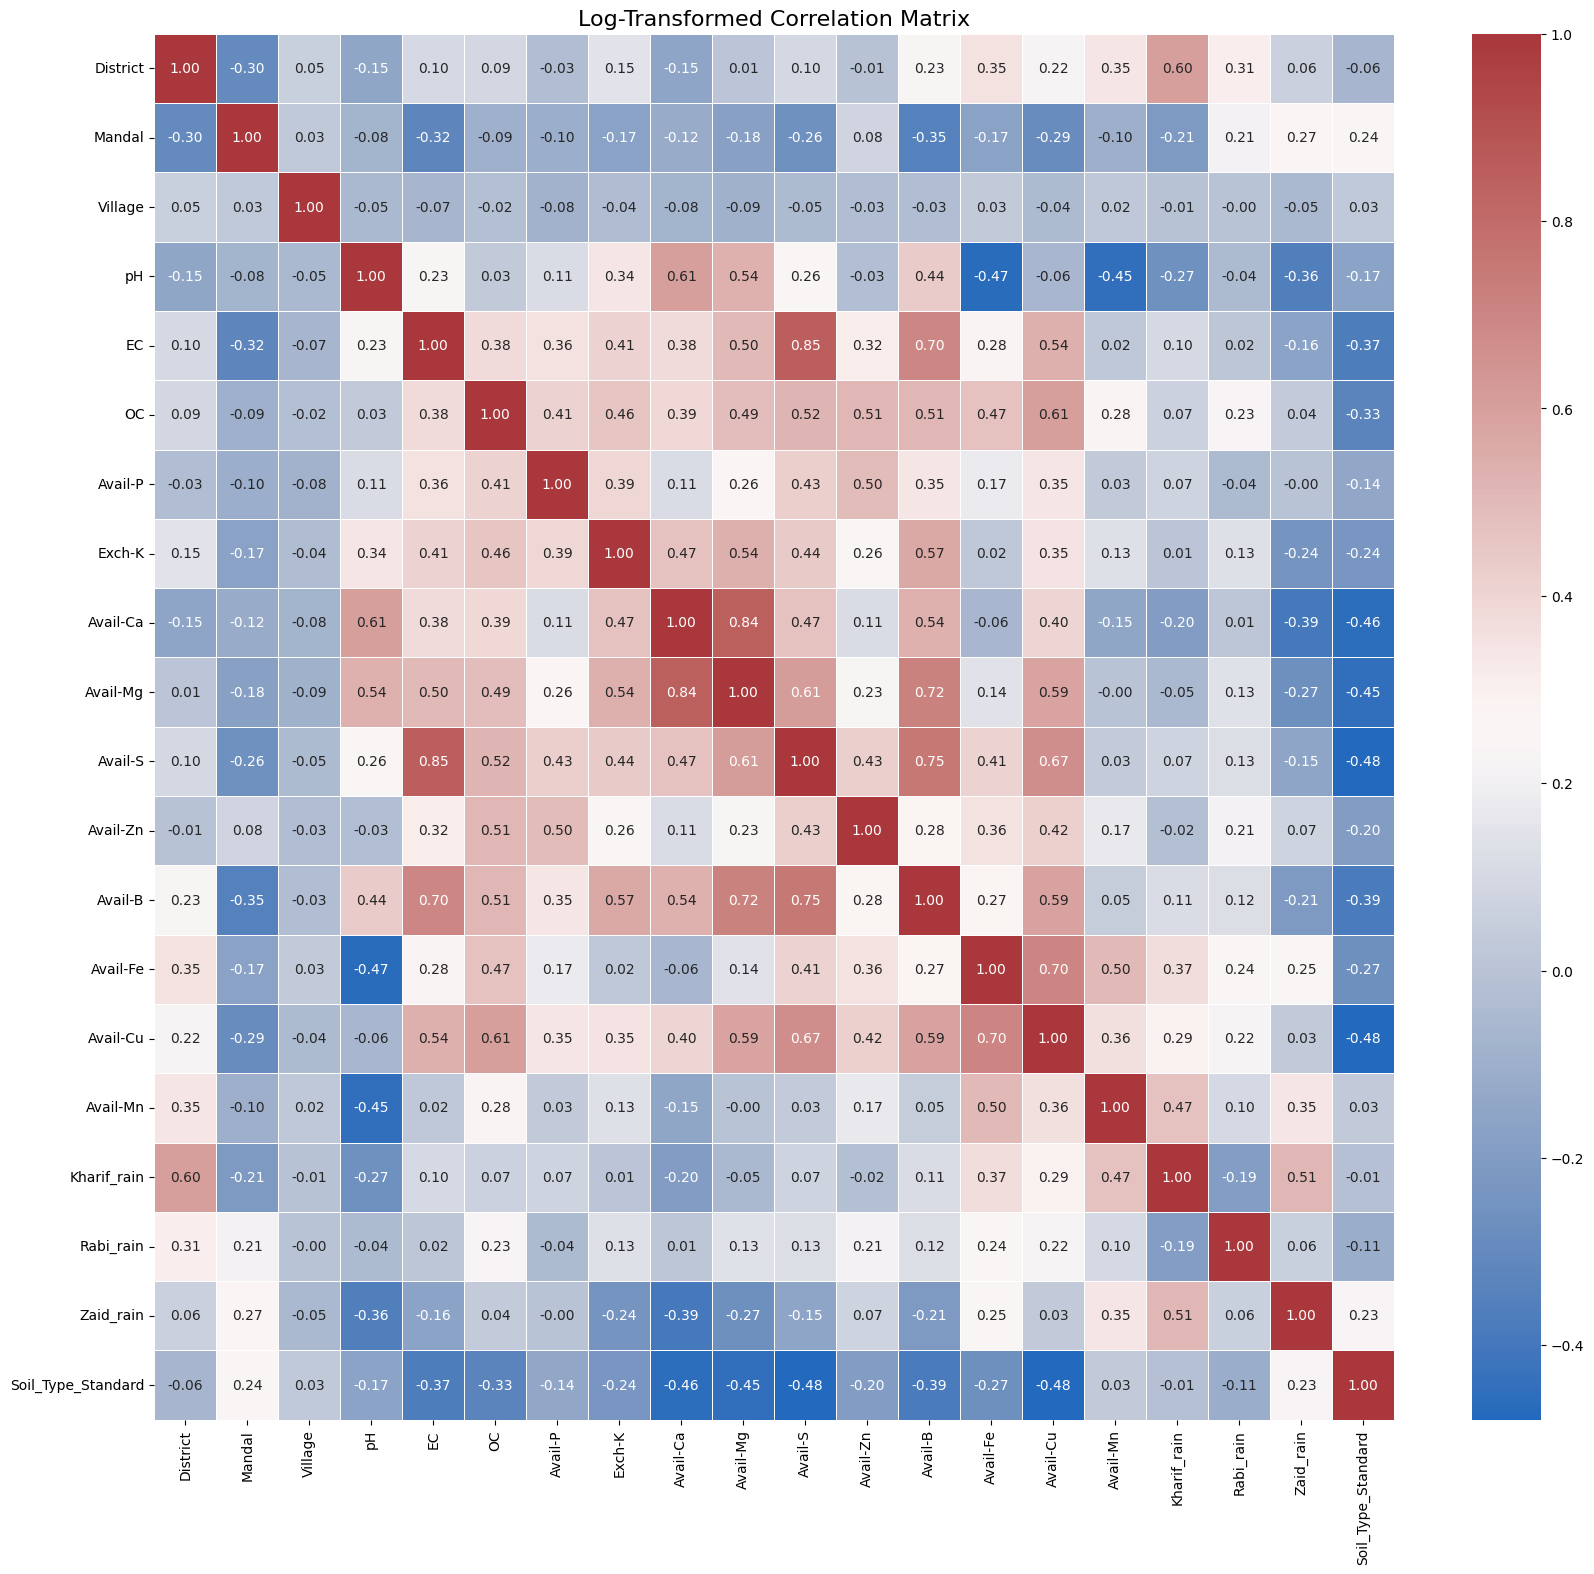

Identified features to drop (correlation > 0.80): []
Highly correlated features removed.


In [49]:
X_analysis = df_final.drop(columns=['First_Crop']) # Start with a clean slate for analysis
for col in ['District', 'Mandal', 'Village', 'Soil_Type_Standard']:
    if col in X_analysis.columns:
        X_analysis[col] = LabelEncoder().fit_transform(X_analysis[col].astype(str))
numerical_features = X_analysis.select_dtypes(include=np.number).columns
X_log_transformed = np.log1p(X_analysis[numerical_features])
plt.figure(figsize=(20, 18))
sns.heatmap(X_log_transformed.corr(), annot=True, cmap='vlag', fmt='.2f', linewidths=.5)
plt.title('Log-Transformed Correlation Matrix', fontsize=16)
plt.show()

corr_matrix = X_analysis[numerical_features].corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.80)]
print(f"Identified features to drop (correlation > 0.80): {to_drop}")
df_final.drop(columns=to_drop, inplace=True)
print("Highly correlated features removed.")

Feature Selection: Based on the heatmap, we programmatically identify and remove features with a correlation greater than 0.80. In our case, this removes `Avail-S` and `Avail-Mg`, which are highly redundant with `EC` and `Avail-Ca`, respectively. This prevents model instability and reduces complexity.

Nutrient Distribution across Crops

We generate box plots to visualize how the distributions of key soil nutrients (like `pH`, `EC`, `OC`) differ across the major crop types. This helps confirm that these features are valuable predictors.


Generating Box Plots for Nutrient Distribution Across Top 15 Crops...


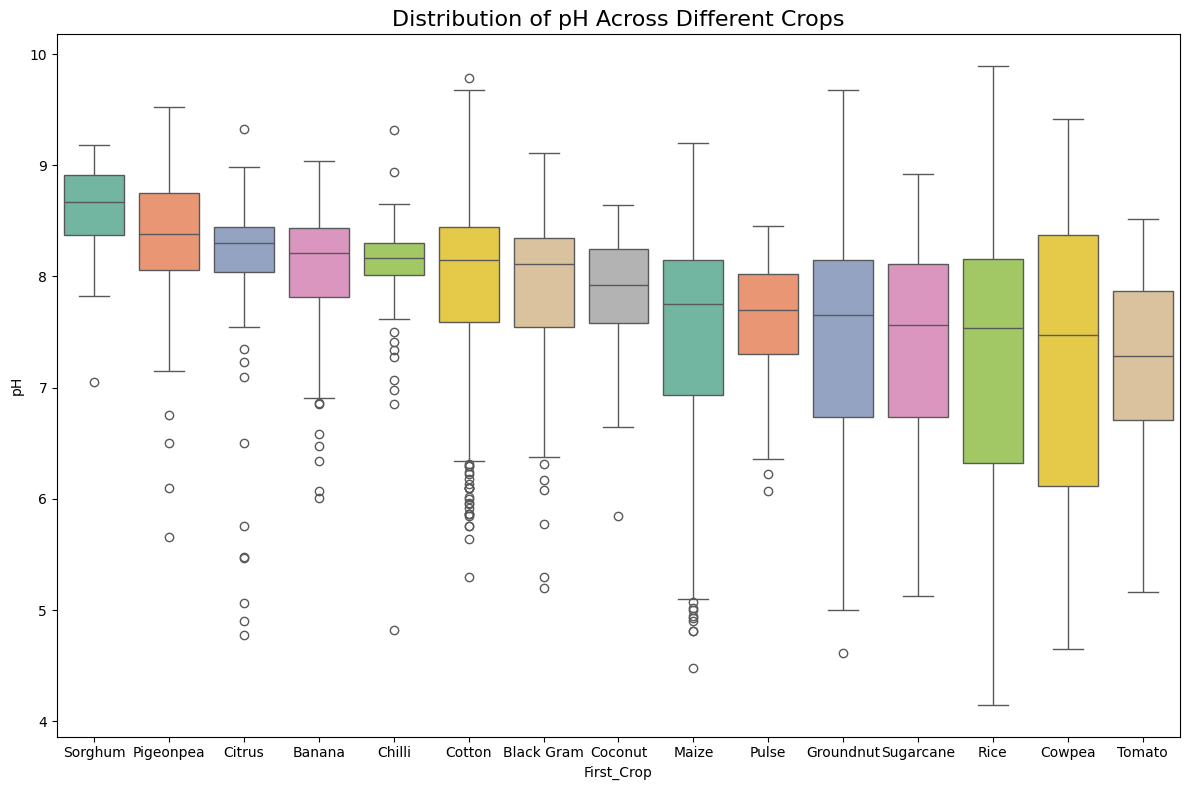

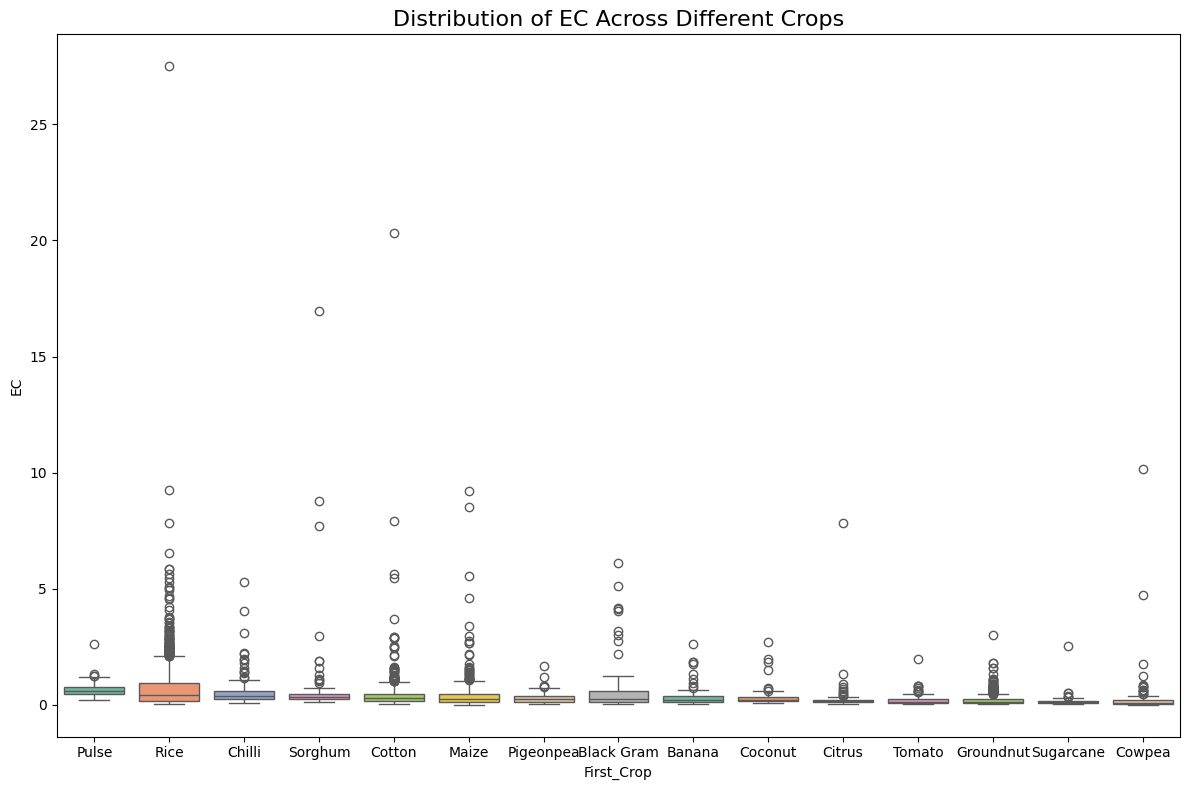

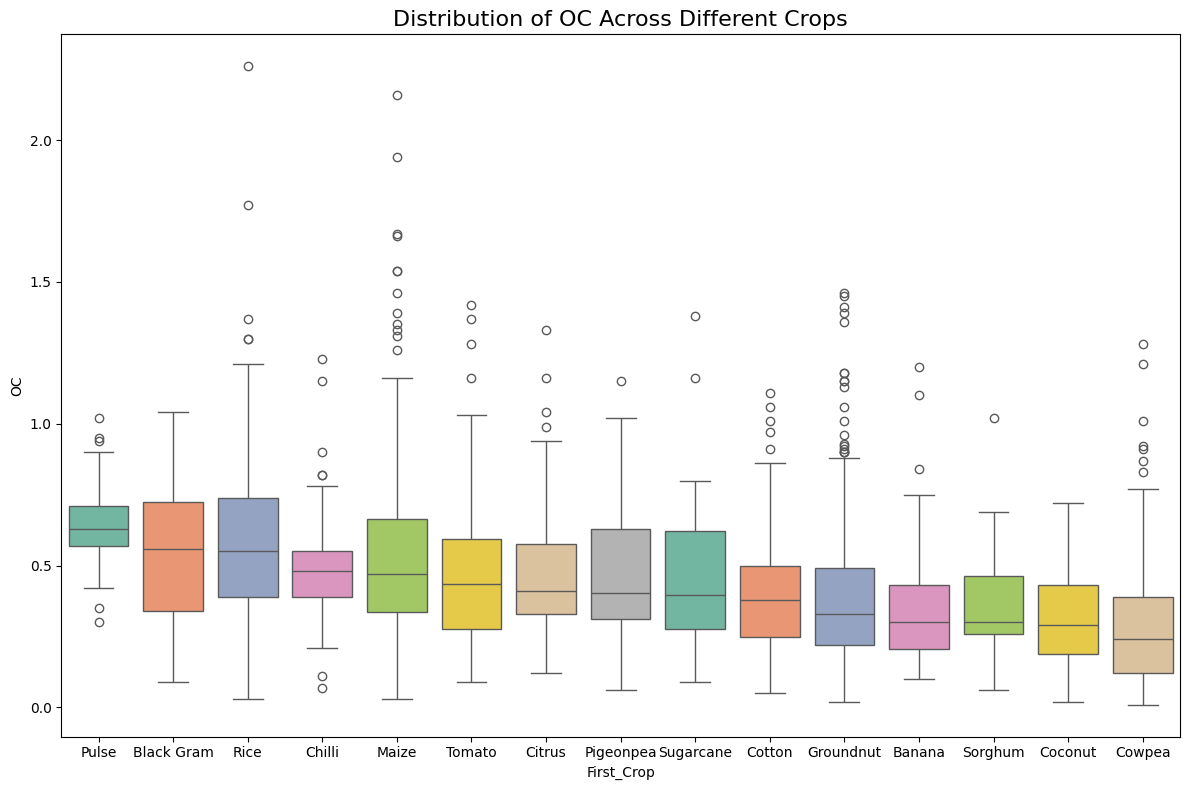

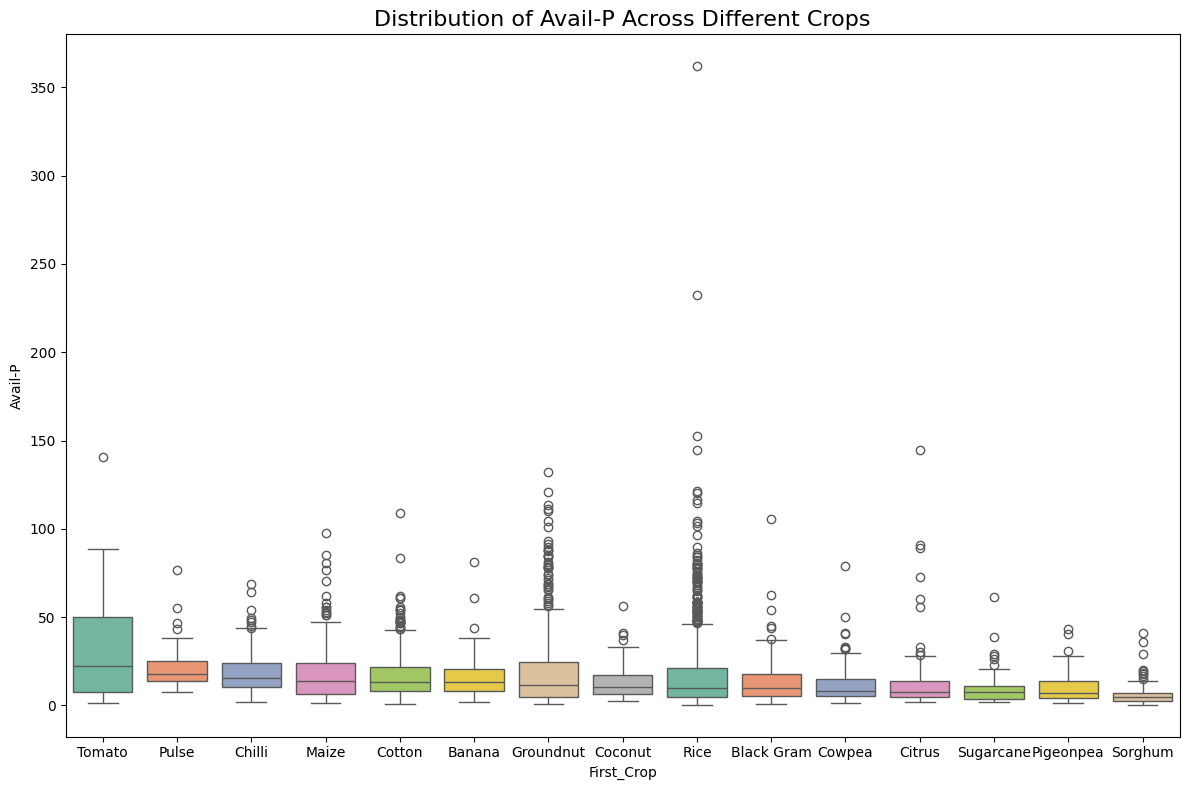

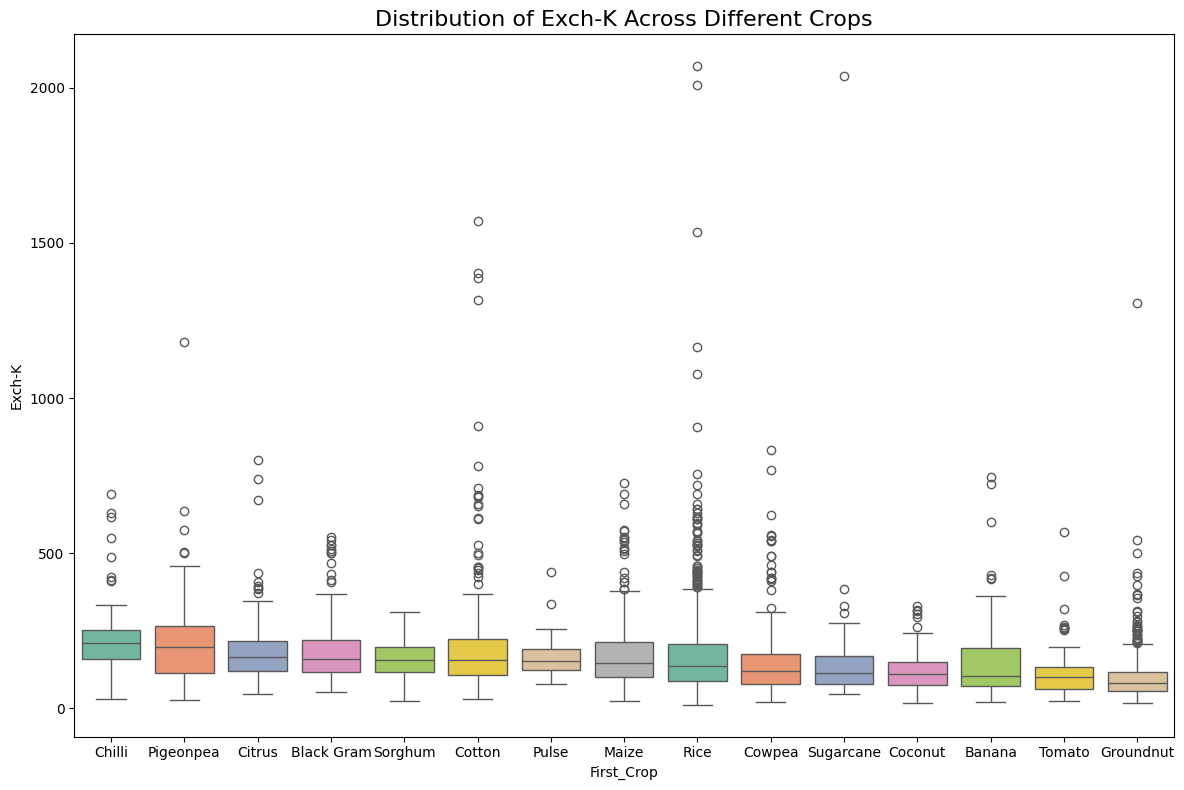

In [50]:
print("\nGenerating Box Plots for Nutrient Distribution Across Top 15 Crops...")
nutrient_features_for_boxplot = ['pH', 'EC', 'OC', 'Avail-P', 'Exch-K']
for nutrient in nutrient_features_for_boxplot:
    order = df_final.groupby('First_Crop')[nutrient].median().sort_values(ascending=False).index
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='First_Crop', y=nutrient, data=df_final, order=order, palette='Set2')
    plt.title(f'Distribution of {nutrient} Across Different Crops', fontsize=16)
    plt.tight_layout()
    plt.show()

DATA PREPARATION For Modelling

In [51]:
categorical_features = ['District', 'Mandal', 'Village', 'Soil_Type_Standard']
le_crop = LabelEncoder()
df_final['First_Crop_encoded'] = le_crop.fit_transform(df_final['First_Crop'])
X = df_final.drop(columns=['First_Crop', 'First_Crop_encoded'])
y = df_final['First_Crop_encoded']
for col in categorical_features:
    if col in X.columns:
        X[col] = LabelEncoder().fit_transform(X[col].astype(str))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
numerical_features_to_scale = [col for col in X.columns if col not in categorical_features]
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

PCA Analysis and Visualization


Generating PCA vs. Accuracy Plot for Documentation...


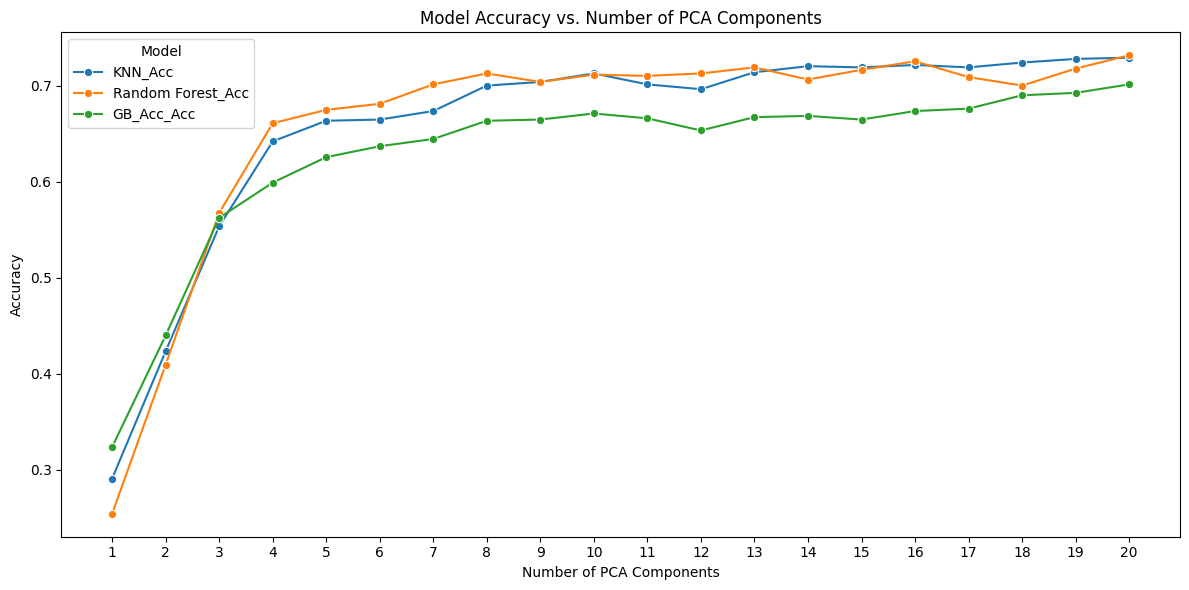

In [52]:
print("\nGenerating PCA vs. Accuracy Plot for Documentation...")
all_res = []
models_for_pca = {
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "GB_Acc": GradientBoostingClassifier(random_state=42)
}
for n in range(1, X_train_scaled.shape[1] + 1):
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    res = {'PCA_Cols': n}
    for name, model in models_for_pca.items():
        model.fit(X_train_pca, y_train)
        res[f'{name}_Acc'] = model.score(X_test_pca, y_test)
    all_res.append(res)

all_res_df = pd.DataFrame(all_res)
all_res_melted = all_res_df.melt(id_vars="PCA_Cols", var_name="Model", value_name="Accuracy")

plt.figure(figsize=(12, 6))
sns.lineplot(data=all_res_melted, x="PCA_Cols", y="Accuracy", hue="Model", marker="o")
plt.title("Model Accuracy vs. Number of PCA Components")
plt.xlabel("Number of PCA Components"); plt.ylabel("Accuracy")
plt.xticks(all_res_df['PCA_Cols'].unique())
plt.legend(title="Model"); plt.tight_layout(); plt.show()

In [53]:
%pip install catboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


INDIVIDUAL MODEL COMPARISON WITH SMOTE



**Address Class Imbalance with SMOTE**
This is the most critical step to fix the poor performance on minority classes. SMOTE (Synthetic Minority Over-sampling Technique) will create synthetic samples for the rare crops in your training data, giving the model more to learn from.

It is crucial to use SMOTE within a pipeline to avoid data leakage. This ensures that the synthetic data is only generated from the training set during each cross-validation fold.


--- Training, Tuning and Evaluating Models ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5087
[LightGBM] [Info] Number of data points in the train set: 16875, number of used features: 20
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Inf

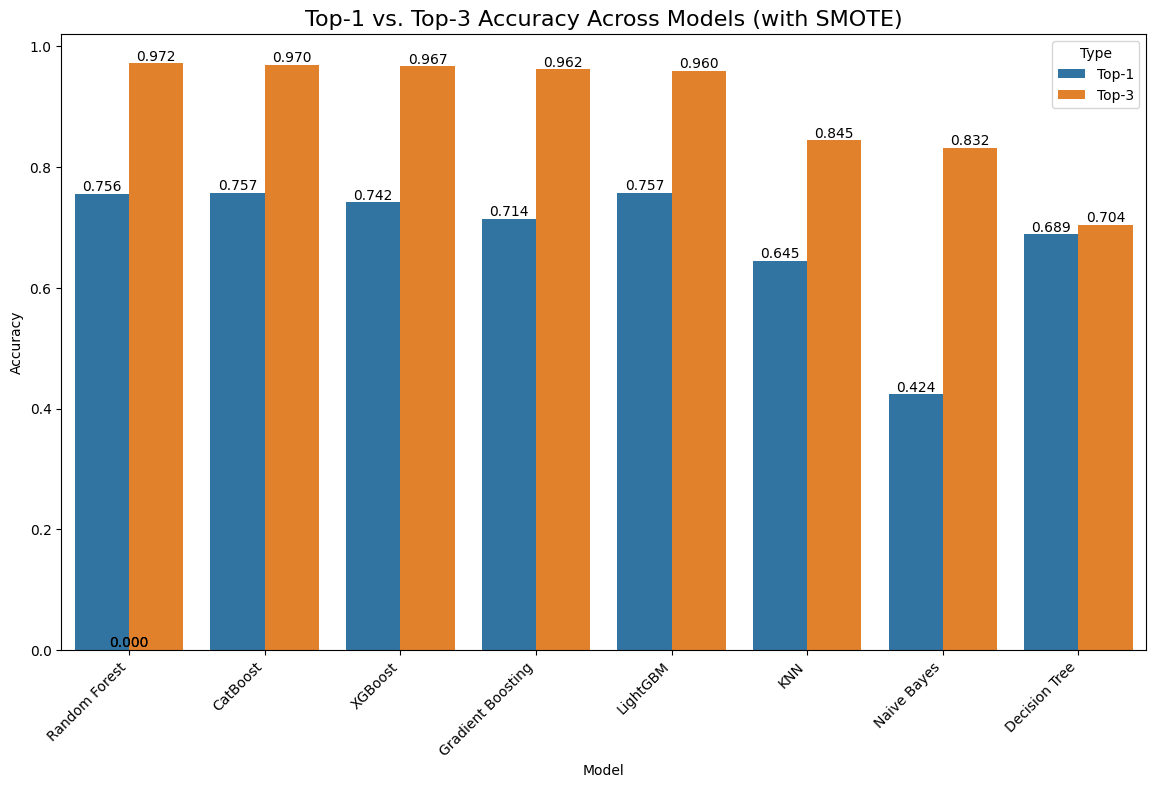

In [54]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

print("\n--- Training, Tuning and Evaluating Models ---")
models = {
    "Naive Bayes": GaussianNB(), "KNN": KNeighborsClassifier(n_neighbors=7),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    "CatBoost": cb.CatBoostClassifier(random_state=42, verbose=0)
}
model_results = []
for name, model in models.items():
    pipeline = ImbPipeline([('smote', SMOTE(random_state=42)), ('model', model)])
    pipeline.fit(X_train_scaled, y_train)
    y_probas = pipeline.predict_proba(X_test_scaled)
    y_pred_top1 = np.argmax(y_probas, axis=1)
    accuracy_top1 = accuracy_score(y_test, y_pred_top1)
    accuracy_top3 = np.mean([1 if y_test.iloc[i] in np.argsort(y_probas[i])[-3:] else 0 for i in range(len(y_test))])
    model_results.append({'Model': name, 'Accuracy': accuracy_top1, 'Type': 'Top-1'})
    model_results.append({'Model': name, 'Accuracy': accuracy_top3, 'Type': 'Top-3'})
results_df = pd.DataFrame(model_results)
model_order = results_df.query("Type == 'Top-3'").sort_values('Accuracy', ascending=False)['Model']
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Model', y='Accuracy', hue='Type', data=results_df, order=model_order)
ax.set_title('Top-1 vs. Top-3 Accuracy Across Models (with SMOTE)', fontsize=16)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.xticks(rotation=45, ha='right'); plt.show()

HYPERPARAMETER TUNING FOR TOP 3 MODELS

The top 3 models from the baseline comparison are selected for hyperparameter tuning using `GridSearchCV`. This process systematically searches for the optimal parameters to maximize each model's performance.

In [56]:
from sklearn.model_selection import GridSearchCV

top_3_models_names = results_df.sort_values('Accuracy', ascending=False).drop_duplicates('Model').head(3)['Model'].tolist()
print(f"\n--- Hyperparameter Tuning for Top 3 Models: {top_3_models_names} ---")
tuned_estimators = {}
param_grids = {
    'Random Forest': {'model__n_estimators': [200, 400], 'model__max_depth': [20, None]},
    'LightGBM': {'model__n_estimators': [300, 500], 'model__learning_rate': [0.05, 0.1]},
    'XGBoost': {'model__n_estimators': [300, 500], 'model__max_depth': [5, 7]},
    'CatBoost': {'model__n_estimators': [200, 400], 'model__max_depth': [6, 8], 'model__learning_rate': [0.05, 0.1]}

}
for model_name in top_3_models_names:
    print(f"\nTuning {model_name}...")
    pipeline = ImbPipeline([('smote', SMOTE(random_state=42)), ('model', models[model_name])])
    if model_name in param_grids:
        grid_search = GridSearchCV(pipeline, param_grids[model_name], scoring='accuracy', cv=3, n_jobs=-1, verbose=1)
        grid_search.fit(X_train_scaled, y_train)
        tuned_estimators[model_name] = grid_search.best_estimator_
        print(f"Best Params for {model_name}: {grid_search.best_params_}")


--- Hyperparameter Tuning for Top 3 Models: ['Random Forest', 'CatBoost', 'XGBoost'] ---

Tuning Random Forest...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Params for Random Forest: {'model__max_depth': 20, 'model__n_estimators': 200}

Tuning CatBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Params for CatBoost: {'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 400}

Tuning XGBoost...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Params for XGBoost: {'model__max_depth': 5, 'model__n_estimators': 500}


Final Ensemble Model

A Soft Voting Classifier is created using the three tuned models (Random Forest, XGBoost, and LightGBM). Soft voting averages the prediction probabilities from each model, leading to a more robust and accurate final decision.
The ensemble model is trained on the SMOTE-resampled training data.

In [57]:
final_estimators_for_voter = [(name, pipeline.named_steps['model']) for name, pipeline in tuned_estimators.items()]
smote_final = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote_final.fit_resample(X_train_scaled, y_train)
ensemble_model = VotingClassifier(estimators=final_estimators_for_voter, voting='soft')
print("\nFitting the final ensemble model on resampled data...")
ensemble_model.fit(X_train_resampled, y_train_resampled)


Fitting the final ensemble model on resampled data...


,estimators,"[('Random Forest', ...), ('CatBoost', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,n_estimators,200
,criterion,'gini'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1


The final, trained ensemble model is saved to a file named **`final_crop_model.pkl`** using `pickle`. This file is the deployable asset that can be used in a real-world application.

In [58]:
print("\n--- Building, Evaluating Final Ensemble & Saving Model ---")
final_estimators_for_voter = [(name, pipeline.named_steps['model']) for name, pipeline in tuned_estimators.items()]
smote_final = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote_final.fit_resample(X_train_scaled, y_train)
ensemble_model = VotingClassifier(estimators=final_estimators_for_voter, voting='soft')
print("Fitting the final ensemble model...")
ensemble_model.fit(X_train_resampled, y_train_resampled)
filename = 'final_crop_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(ensemble_model, file)
print(f"Final ensemble model saved as '{filename}'")


--- Building, Evaluating Final Ensemble & Saving Model ---
Fitting the final ensemble model...
Final ensemble model saved as 'final_crop_model.pkl'


FINAL MODEL SHOWDOWN: ENSEMBLE vs. INDIVIDUALS

In [59]:
print("\n--- Final Model Showdown: Ensemble vs. Best Individuals ---")

final_models = {}
final_models.update(tuned_estimators)
final_estimators_for_voter = []
for name, pipeline in tuned_estimators.items():
    final_estimators_for_voter.append((name, pipeline.named_steps['model']))


ensemble_model = VotingClassifier(
    estimators=final_estimators_for_voter,
    voting='soft'
)

smote_final = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote_final.fit_resample(X_train_scaled, y_train)

print("Fitting the final ensemble model on resampled data...")
ensemble_model.fit(X_train_resampled, y_train_resampled)
final_models['Soft Voting Ensemble'] = ensemble_model


--- Final Model Showdown: Ensemble vs. Best Individuals ---
Fitting the final ensemble model on resampled data...


In [65]:
y_probas_final = ensemble_model.predict_proba(X_test_scaled)
y_pred_final_top1 = np.argmax(y_probas_final, axis=1)
accuracy_top1_final = accuracy_score(y_test, y_pred_final_top1)
top_3_indices_final = np.argsort(y_probas_final, axis=1)[:, -3:]
accuracy_top3_final = np.mean([1 if y_test.iloc[i] in top_3_indices_final[i] else 0 for i in range(len(y_test))])
report_final = classification_report(y_test, y_pred_final_top1, target_names=le_crop.classes_)

print("\n--- PERFORMANCE OF FINAL ENSEMBLE MODEL ---")
print(f"Final Top-1 Accuracy: {accuracy_top1_final:.4f}")
print(f"Final Top-3 Accuracy: {accuracy_top3_final:.4f}\n")


--- PERFORMANCE OF FINAL ENSEMBLE MODEL ---
Final Top-1 Accuracy: 0.7497
Final Top-3 Accuracy: 0.9697



EVALUATE ALL CONTENDERS AND VISUALIZE


--- Evaluating All Final Contenders ---
  Random Forest -> Top-1 Acc: 0.7522, Top-3 Acc: 0.9697
  CatBoost -> Top-1 Acc: 0.7269, Top-3 Acc: 0.9684
  XGBoost -> Top-1 Acc: 0.7535, Top-3 Acc: 0.9659
  Soft Voting Ensemble -> Top-1 Acc: 0.7497, Top-3 Acc: 0.9697


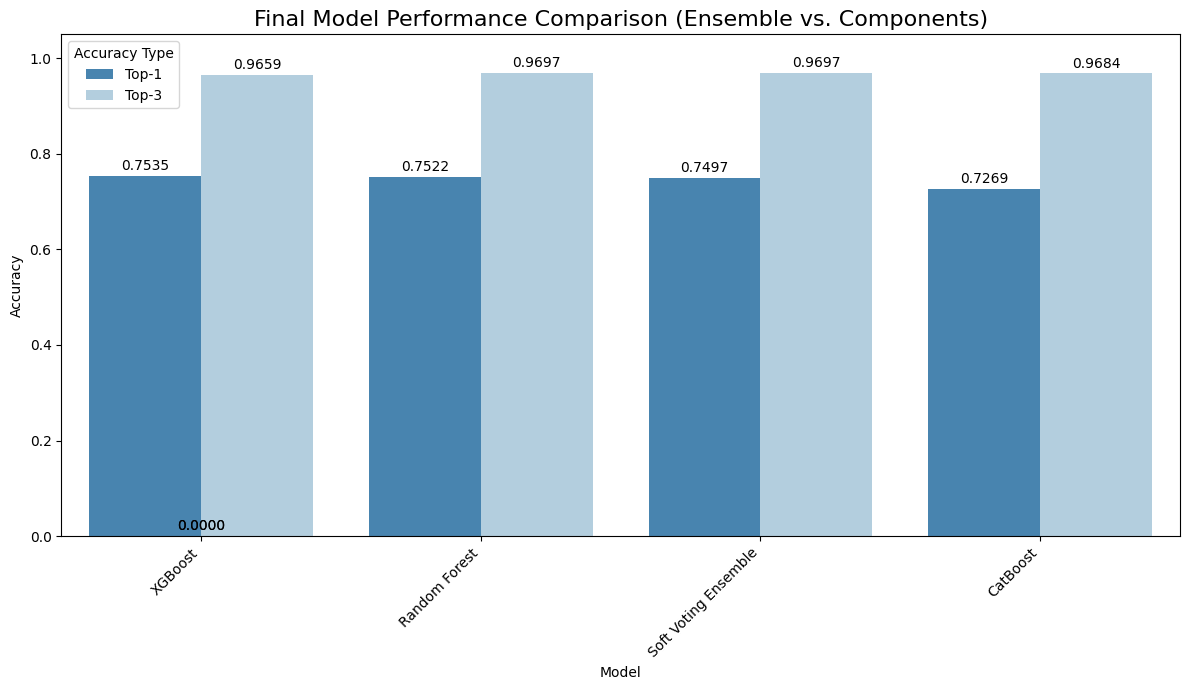

In [66]:
print("\n--- Evaluating All Final Contenders ---")

final_model_results = []
for name, model in final_models.items():
    # All models are fitted and can predict on the scaled test set
    y_probas = model.predict_proba(X_test_scaled)

    # Calculate Top-1 Accuracy
    y_pred_top1 = np.argmax(y_probas, axis=1)
    accuracy_top1 = accuracy_score(y_test, y_pred_top1)

    # Calculate Top-3 Accuracy
    top_3_indices = np.argsort(y_probas, axis=1)[:, -3:]
    accuracy_top3 = np.mean([1 if y_test.iloc[i] in top_3_indices[i] else 0 for i in range(len(y_test))])

    final_model_results.append({'Model': name, 'Accuracy': accuracy_top1, 'Type': 'Top-1'})
    final_model_results.append({'Model': name, 'Accuracy': accuracy_top3, 'Type': 'Top-3'})

    print(f"  {name} -> Top-1 Acc: {accuracy_top1:.4f}, Top-3 Acc: {accuracy_top3:.4f}")

# --- Visualize Final Model Performance ---
results_final_df = pd.DataFrame(final_model_results)
# Order the chart by the best Top-1 accuracy for clarity
model_order_final = results_final_df.query("Type == 'Top-1'").sort_values('Accuracy', ascending=False)['Model']

plt.figure(figsize=(12, 7))
ax = sns.barplot(x='Model', y='Accuracy', hue='Type', data=results_final_df, order=model_order_final, palette='Blues_r')
ax.set_title('Final Model Performance Comparison (Ensemble vs. Components)', fontsize=16)
ax.set_ylim(0, 1.05)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.4f}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black',
                xytext=(0, 7), textcoords='offset points')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Accuracy Type')
plt.tight_layout()
plt.show()

SELECT, SAVE, AND REPORT ON THE BEST MODEL

We conduct a thorough evaluation of the final ensemble model on the unseen test set, generating a detailed **Classification Report** with Precision, Recall, and F1-Scores.

In [67]:
print("\n--- Selecting Best Overall Model and Saving for Deployment ---")

# Automatically select the best model based on Top-1 Accuracy
best_model_name = results_final_df.query("Type == 'Top-1'").sort_values('Accuracy', ascending=False).iloc[0]['Model']
best_overall_model = final_models[best_model_name]
print(f"The best performing model is: '{best_model_name}'")

# --- Save the final best model to a .pkl file ---
filename = 'final_crop_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_overall_model, file)
print(f"\nBest model saved successfully as '{filename}'")
print(f"This file contains the trained '{best_model_name}' model and can be loaded for predictions.")

# --- Detailed Final Report for the Winning Model ---
y_probas_best = best_overall_model.predict_proba(X_test_scaled)
y_pred_best_top1 = np.argmax(y_probas_best, axis=1)
report_final = classification_report(y_test, y_pred_best_top1, target_names=le_crop.classes_)

print("\n--- FINAL PERFORMANCE REPORT FOR THE WINNING MODEL ---")
print(f"Model Name: {best_model_name}")
print(f"Top-1 Accuracy: {accuracy_score(y_test, y_pred_best_top1):.4f}")
print(f"Top-3 Accuracy: {np.mean([1 if y_test.iloc[i] in np.argsort(y_probas_best[i])[-3:] else 0 for i in range(len(y_test))]):.4f}\n")
print("Detailed Classification Report (Precision, Recall, F1-Score):")
print(report_final)


--- Selecting Best Overall Model and Saving for Deployment ---
The best performing model is: 'XGBoost'

Best model saved successfully as 'final_crop_model.pkl'
This file contains the trained 'XGBoost' model and can be loaded for predictions.

--- FINAL PERFORMANCE REPORT FOR THE WINNING MODEL ---
Model Name: XGBoost
Top-1 Accuracy: 0.7535
Top-3 Accuracy: 0.9659

Detailed Classification Report (Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      Banana       0.47      0.47      0.47        19
  Black Gram       0.53      0.68      0.59        28
      Chilli       0.61      0.48      0.54        23
      Citrus       0.75      0.78      0.77        23
     Coconut       0.17      0.07      0.10        14
      Cotton       0.65      0.68      0.67        98
      Cowpea       0.70      0.79      0.74        42
   Groundnut       0.81      0.80      0.80       119
       Maize       0.77      0.68      0.72        74
   Pigeonpea       0.39      0.

Learning Curve for Final Model

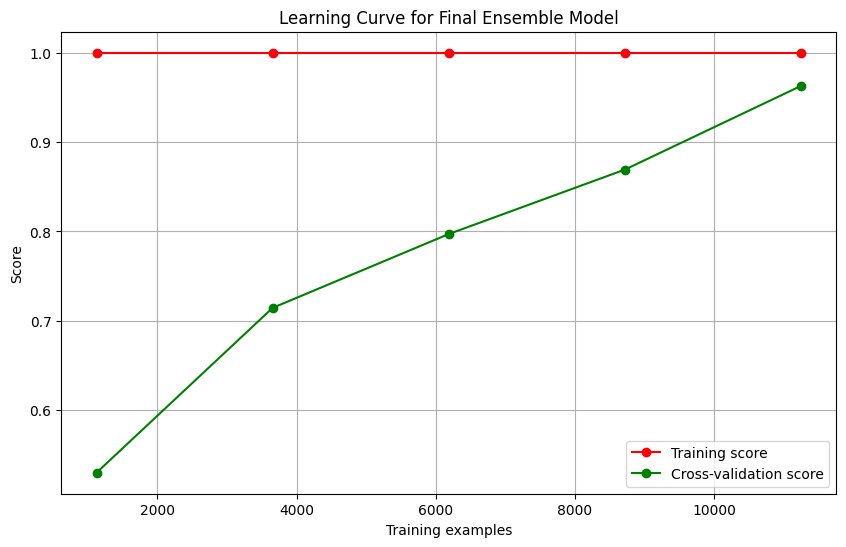

In [68]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(ensemble_model, X_train_resampled, y_train_resampled, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.figure(figsize=(10,6))
plt.grid()
plt.title("Learning Curve for Final Ensemble Model")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.legend(loc="best")
plt.show()

Confusion Matrix

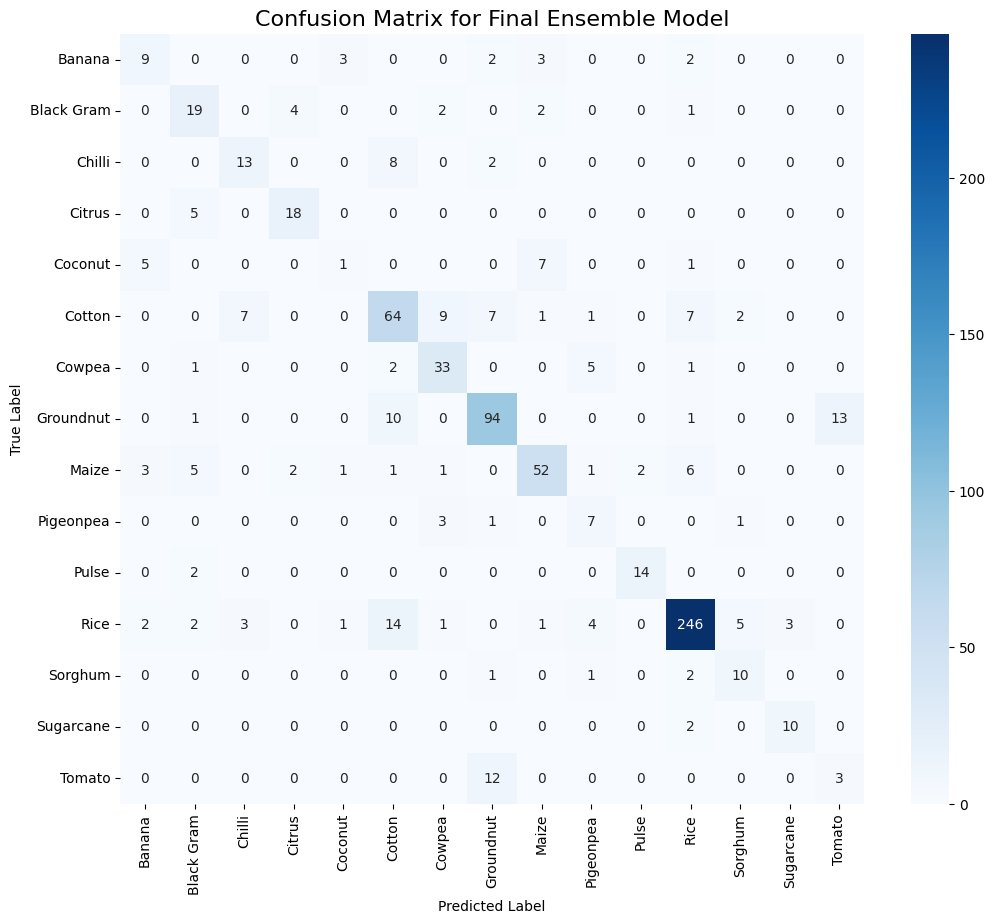

In [69]:
cm = confusion_matrix(y_test, y_pred_final_top1)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_crop.classes_, yticklabels=le_crop.classes_)
plt.title('Confusion Matrix for Final Ensemble Model', fontsize=16)
plt.xlabel('Predicted Label'); plt.ylabel('True Label')
plt.show()

Top-3 Recommendation Demonstration

This final step demonstrates the practical application of our trained model. We define a function, `get_top_n_recommendations`, that simulates how the backend of a mobile app would work. It takes a soil sample's data, loads the saved `final_crop_model.pkl`, and predicts the top 3 most suitable crops.
The output provides a clear, ranked list, giving the farmer flexible and actionable advice.

In [70]:
def get_top_n_recommendations(sample_data, model, crop_encoder, n=3):
    probabilities = model.predict_proba(sample_data)[0]
    top_n_indices = np.argsort(probabilities)[-n:][::-1]
    top_n_crops = crop_encoder.inverse_transform(top_n_indices)
    return [{"Rank": i + 1, "Recommended Crop": top_n_crops[i]} for i in range(n)]

sample_indices = [15, 50, 100]
for i, sample_index in enumerate(sample_indices):
    if sample_index < len(X_test_scaled):
        sample = X_test_scaled[sample_index:sample_index+1]
        true_crop_name = le_crop.inverse_transform([y_test.iloc[sample_index]])[0]
        top_3_recs = get_top_n_recommendations(sample, ensemble_model, le_crop, n=3)
        print(f"\n--- Recommendation for Sample #{sample_index} | Actual Crop: {true_crop_name} ---")
        print(pd.DataFrame(top_3_recs).to_string(index=False))


--- Recommendation for Sample #15 | Actual Crop: Groundnut ---
 Rank Recommended Crop
    1        Groundnut
    2        Pigeonpea
    3           Tomato

--- Recommendation for Sample #50 | Actual Crop: Maize ---
 Rank Recommended Crop
    1            Maize
    2           Banana
    3             Rice

--- Recommendation for Sample #100 | Actual Crop: Rice ---
 Rank Recommended Crop
    1             Rice
    2            Maize
    3           Banana


In [71]:
print("\n--- Demonstration of Top-3 Crop Recommendations ---")
def get_top_n_recommendations(sample_data, model, crop_encoder, n=3):
    probabilities = model.predict_proba(sample_data)[0]
    top_n_indices = np.argsort(probabilities)[-n:][::-1]
    top_n_crops = crop_encoder.inverse_transform(top_n_indices)
    return [{"Rank": i + 1, "Recommended Crop": top_n_crops[i]} for i in range(n)]

sample_indices = [25, 75, 120]
for i, sample_index in enumerate(sample_indices):
    if sample_index < len(X_test_scaled):
        sample = X_test_scaled[sample_index:sample_index+1]
        true_crop_name = le_crop.inverse_transform([y_test.iloc[sample_index]])[0]
        top_3_recs = get_top_n_recommendations(sample, ensemble_model, le_crop, n=3)
        print(f"\n--- Recommendation for Sample #{sample_index} | Actual Crop: {true_crop_name} ---")
        print(pd.DataFrame(top_3_recs).to_string(index=False))



--- Demonstration of Top-3 Crop Recommendations ---

--- Recommendation for Sample #25 | Actual Crop: Groundnut ---
 Rank Recommended Crop
    1        Groundnut
    2           Tomato
    3          Sorghum

--- Recommendation for Sample #75 | Actual Crop: Rice ---
 Rank Recommended Crop
    1             Rice
    2            Maize
    3           Cotton

--- Recommendation for Sample #120 | Actual Crop: Cotton ---
 Rank Recommended Crop
    1           Cotton
    2       Black Gram
    3            Maize


In [72]:
# 1) Save column order used at training time
import json
with open("columns.json", "w") as f:
    json.dump(list(X_train.columns), f)

# 2) Save the fitted scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# 3) Save encoders for categoricals
encoders = {}
for col in ["District", "Mandal", "Village", "Soil_Type_Standard"]:
    le = LabelEncoder()
    le.fit(X[col].astype(str))   # fit on ALL available categories seen during training
    encoders[col] = le
with open("encoders.pkl", "wb") as f:
    pickle.dump(encoders, f)

# 4) Save the target label encoder (you already have le_crop)
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le_crop, f)

# 5) You already saved the winning model as final_crop_model.pkl
